In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import logging
import os

import numpy as np
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

import utils
import model.net_pretrained as net
import model.data_loader as data_loader
from evaluate import evaluate
from final_metrics import final_metrics
import matplotlib.pyplot as plt






In [2]:
#data_dir = '/home/data/FETAL/30_slice_data'
data_dir = '/home/data/FETAL'
#data_dir= '/home/sbakr/data'
model_dir = 'experiments/lre_3_pretrainedT_augmentF_batchsize8_normalize4densenetF'
restore_file = None 
metrics_filename="metric_data.txt"

In [3]:
def train(model, optimizer, loss_fn, dataloader, metrics, params, epoch_num):
    """Train the model on `num_steps` batches

    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    all_outputs=[]
    all_labels=[]
    loss_avg = utils.RunningAverage()

    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params.cuda:
                train_batch, labels_batch = train_batch.cuda(async=True), labels_batch.cuda(async=True)
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output and loss
            output_batch = model(train_batch)
            loss = loss_fn(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            
            all_labels.append(labels_batch)
            all_outputs.append(output_batch)

            
            # Evaluate summaries only once in a while
            
            if i % params.save_summary_steps == 0:
                #import pdb; pdb.set_trace()
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.cpu().numpy()
                labels_batch = labels_batch.data.cpu().numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                summary_batch['loss'] = loss.data[0]
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.data[0])

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
            
    #import pdb; pdb.set_trace()
    all_labels=torch.cat(all_labels, 0)
    all_outputs=torch.cat(all_outputs, 0)
    
    
    all_predictions = np.argmax((all_outputs.data).cpu().numpy(), axis=1)
    all_labels=all_labels.data.cpu().numpy()
    
    precision, recall, F1, accuracy= final_metrics(all_predictions, all_labels)
    metrics_path = os.path.join(model_dir, metrics_filename)
    with open(metrics_path, "a") as f:
        f.write("train " + str(epoch_num) + " precision " + str(precision) + "\n")
        f.write("train " + str(epoch_num) + " recall " + str(recall) + "\n")
        f.write("train " + str(epoch_num) + " F1 " + str(F1) + "\n")
        f.write("train " + str(epoch_num) + " accuracy " + str(accuracy) + "\n")
        f.write("train " + str(epoch_num) + " loss " + str(loss_avg()) + "\n")
    
    print("precision: %.3f ; recall: %.3f ; F1: %.3f ; accuracy: %.3f" % (precision,recall,F1,accuracy))
    
    
    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)



In [4]:
def plot_metrics():

    train = {"accuracy":{}, "precision":{}, "recall":{}, "F1":{}, "loss":{}}
    eval = {"accuracy":{}, "precision":{}, "recall":{}, "F1":{}, "loss":{}}

    metrics_path = os.path.join(model_dir, metrics_filename)
    with open(metrics_path) as f:
        for lines in f:
            words = lines.split()
            if words[0] == "eval":
                eval[words[2]][words[1]] = words[3]
            elif words[0] == "train":
                train[words[2]][words[1]] = words[3]
            else:
                print("error, a line started with neither train nor eval")

    i = 1
    for keys in eval:
        x = []
        y = []
        x2 = []
        y2 = []
        plt.figure(i)
        plt.ylabel(keys)
        plt.xlabel("Epochs")
        for epochs in eval[keys]:
            x.append(int(epochs))
            y.append(float(train[keys][epochs]))
            x2.append(int(epochs))
            y2.append(float(eval[keys][epochs]))
        plt.plot(x, y)
        plt.plot(x2, y2)
        i += 1
    plt.show()


In [5]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file=None):
    """Train the model and evaluate every epoch.

    Args:
        model: (torch.nn.Module) the neural network
        train_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        val_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches validation data
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) optional- name of file to restore from (without its extension .pth.tar)
    """
    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(model_dir, restore_file + '.pth.tar')
        logging.info("Restoring parameters from {}".format(restore_path))
        utils.load_checkpoint(restore_path, model, optimizer)

    best_val_acc = 0.0

    for epoch in range(params.num_epochs):
        # Run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        train(model, optimizer, loss_fn, train_dataloader, metrics, params, epoch)

        # Evaluate for one epoch on validation set
        val_metrics,precision, recall,F1,accuracy,loss = evaluate(model, loss_fn, val_dataloader, metrics, params)
        metrics_path = os.path.join(model_dir, metrics_filename)
        with open(metrics_path, "a") as f:            
            f.write("eval " + str(epoch) + " precision " + str(precision) + "\n")
            f.write("eval " + str(epoch) + " recall " + str(recall) + "\n")
            f.write("eval " + str(epoch) + " F1 " + str(F1) + "\n")
            f.write("eval " + str(epoch) + " accuracy " + str(accuracy) + "\n")
            f.write("eval " + str(epoch) + " loss " + str(loss) + "\n")
    
        val_acc = val_metrics['accuracy']
        is_best = val_acc>=best_val_acc
        

        print("precision: %.3f ; recall: %.3f ; F1: %.3f ; accuracy: %.3f" % (precision,recall,F1,accuracy))
        plot_metrics()
        # Save weights
        utils.save_checkpoint({'epoch': epoch + 1,
                               'state_dict': model.state_dict(),
                               'optim_dict' : optimizer.state_dict()},
                               is_best=is_best,
                               checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
            logging.info("- Found new best accuracy")
            best_val_acc = val_acc

            # Save best val metrics in a json file in the model directory
            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            utils.save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        utils.save_dict_to_json(val_metrics, last_json_path)



Loading the datasets...
- done.
Starting training for 1000 epoch(s)
Epoch 1/1000
100%|██████████| 352/352 [08:58<00:00,  1.38s/it, loss=0.390]
- Train metrics: accuracy: 0.688 ; Confusion_Matrix: 0.688 ; loss: 0.527


precision: 0.087 ; recall: 0.003 ; F1: 0.005 ; accuracy: 0.738


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 286077.170


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


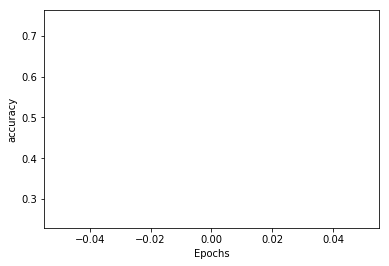

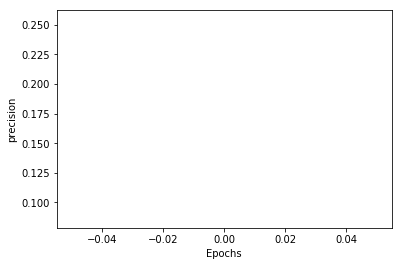

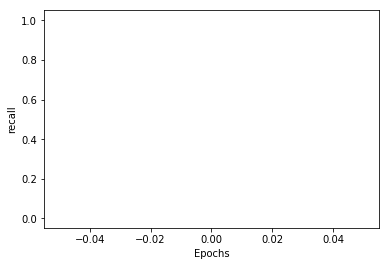

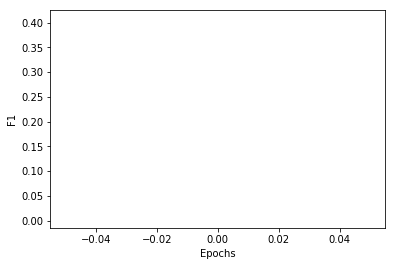

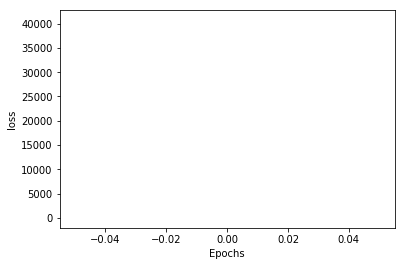

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 2/1000
100%|██████████| 352/352 [08:56<00:00,  1.42s/it, loss=0.364]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.384


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.744


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 125048.389


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


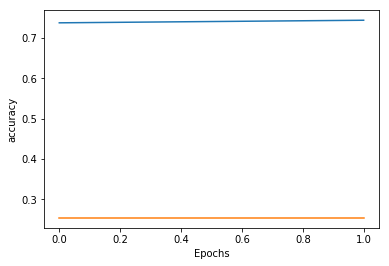

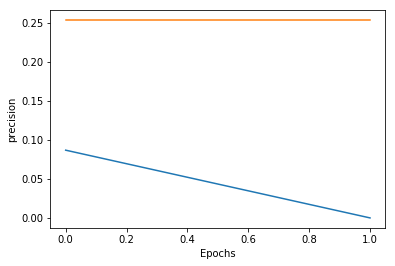

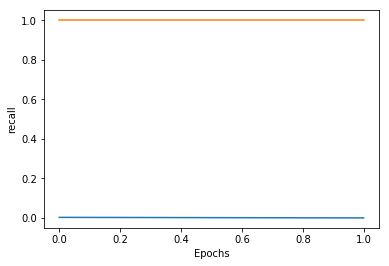

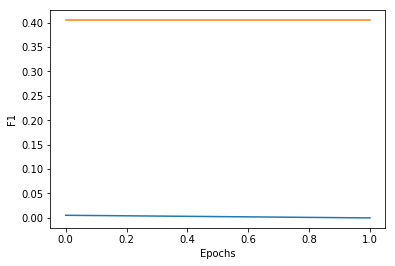

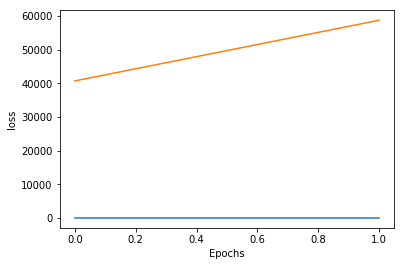

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 3/1000
100%|██████████| 352/352 [09:09<00:00,  1.71s/it, loss=0.361]
- Train metrics: accuracy: 0.688 ; Confusion_Matrix: 0.688 ; loss: 0.399


precision: 0.400 ; recall: 0.003 ; F1: 0.006 ; accuracy: 0.744


- Eval metrics : accuracy: 0.741 ; Confusion_Matrix: 0.741 ; loss: 5.482


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


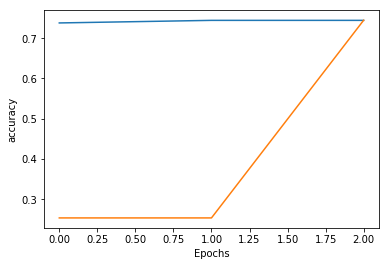

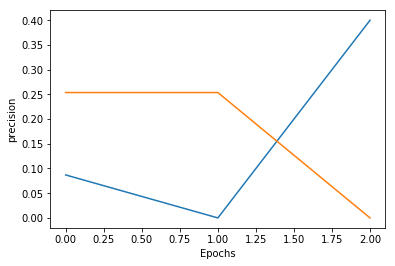

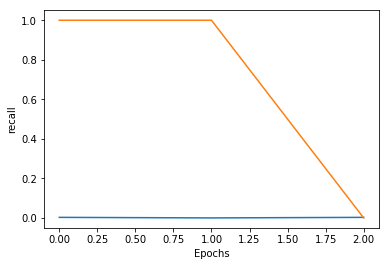

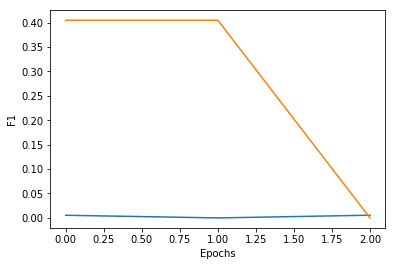

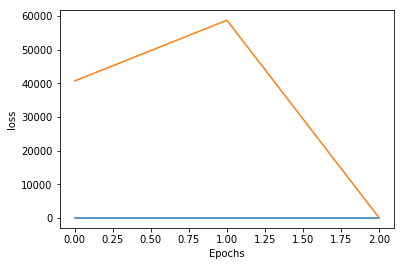

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 4/1000
100%|██████████| 352/352 [10:32<00:00,  1.67s/it, loss=0.366]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.391


precision: 0.500 ; recall: 0.003 ; F1: 0.006 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 6357.808


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


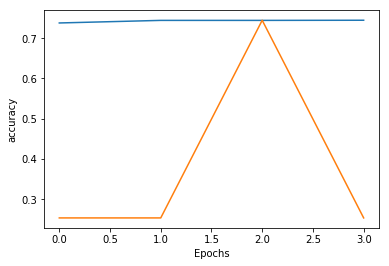

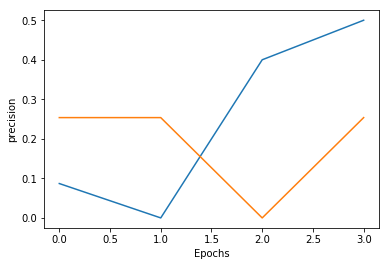

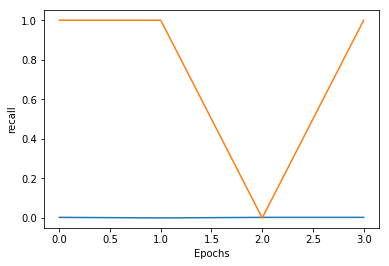

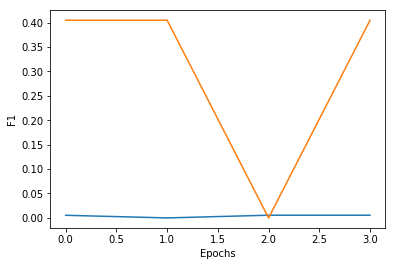

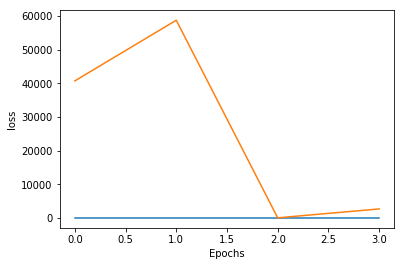

Epoch 5/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:24<00:00,  1.64s/it, loss=0.359]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.314


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.259 ; Confusion_Matrix: 0.259 ; loss: 14153.347


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.255


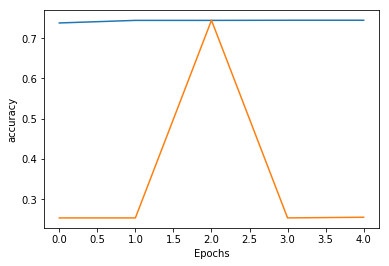

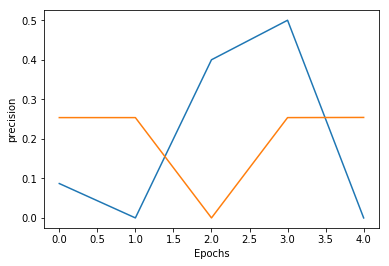

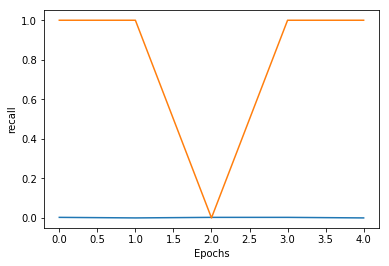

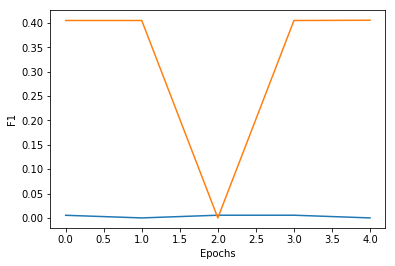

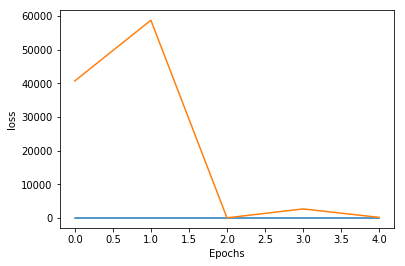

Epoch 6/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:28<00:00,  1.61s/it, loss=0.359]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.289


precision: 0.500 ; recall: 0.001 ; F1: 0.003 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 1410312.296


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


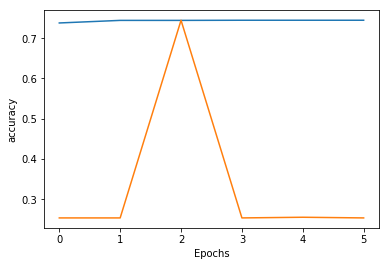

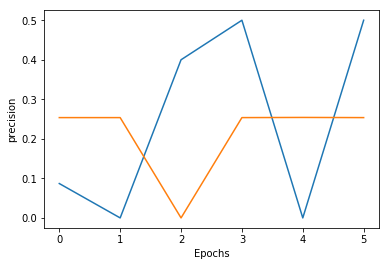

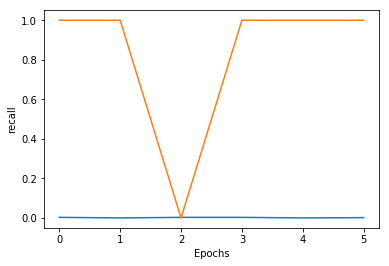

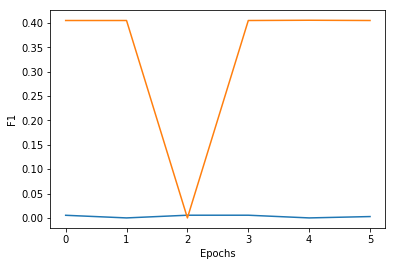

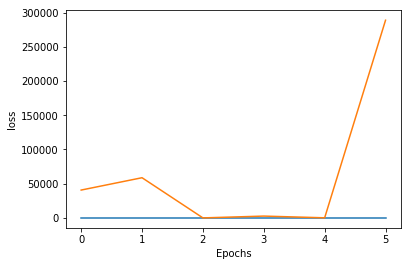

Epoch 7/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:34<00:00,  1.35s/it, loss=0.362]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.460


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.744


- Eval metrics : accuracy: 0.260 ; Confusion_Matrix: 0.260 ; loss: 10701.043


precision: 0.255 ; recall: 1.000 ; F1: 0.406 ; accuracy: 0.257


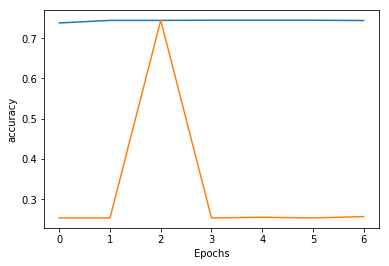

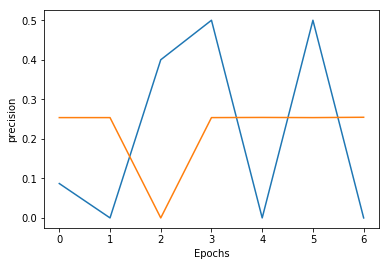

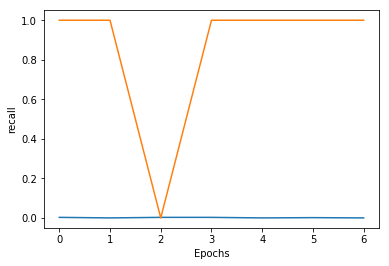

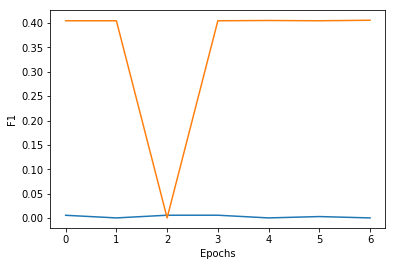

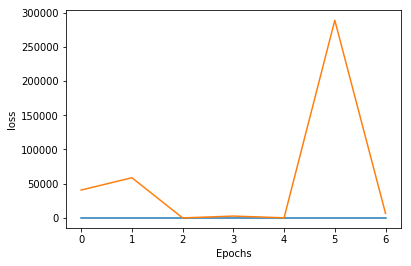

Epoch 8/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:31<00:00,  1.80s/it, loss=0.359]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.308


precision: 0.667 ; recall: 0.003 ; F1: 0.006 ; accuracy: 0.745


- Eval metrics : accuracy: 0.277 ; Confusion_Matrix: 0.277 ; loss: 267.831


precision: 0.258 ; recall: 0.993 ; F1: 0.410 ; accuracy: 0.274


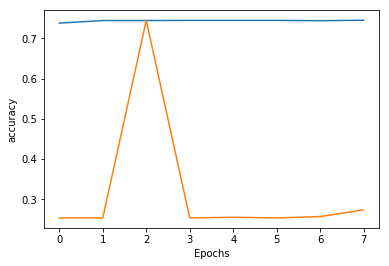

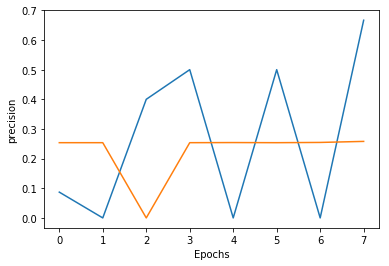

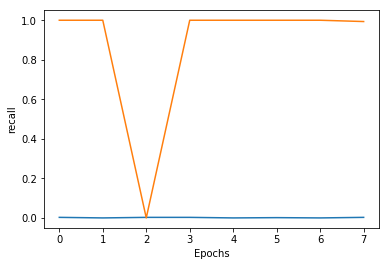

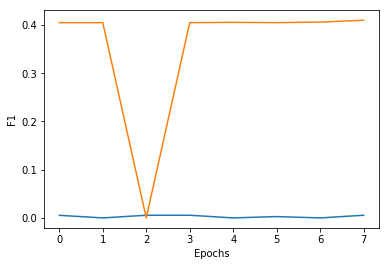

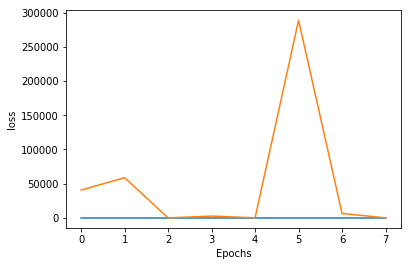

Checkpoint Directory exists! 


Epoch 9/1000
100%|██████████| 352/352 [10:31<00:00,  1.57s/it, loss=0.357]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.399


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 94116256.579


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


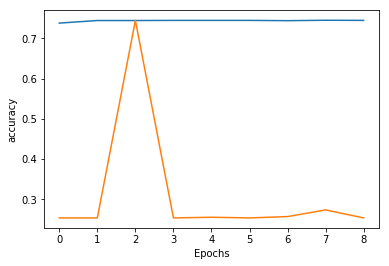

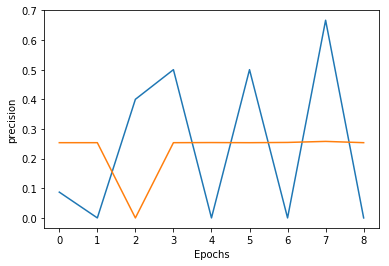

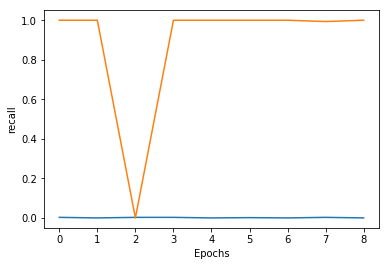

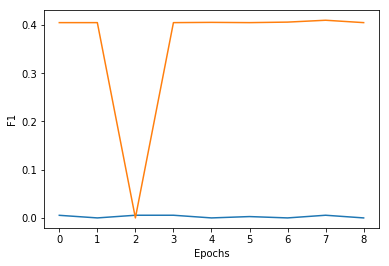

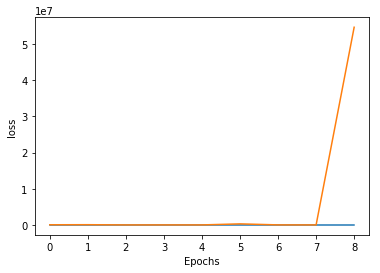

Epoch 10/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:32<00:00,  1.71s/it, loss=0.355]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.350


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 32302.440


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


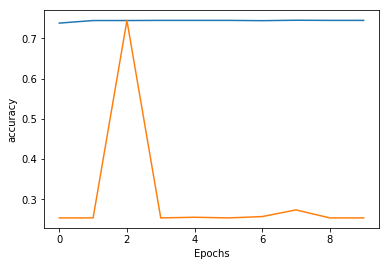

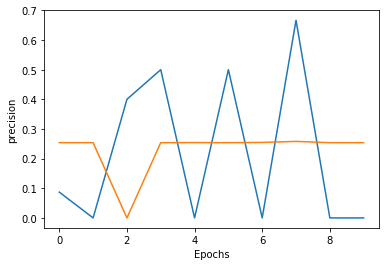

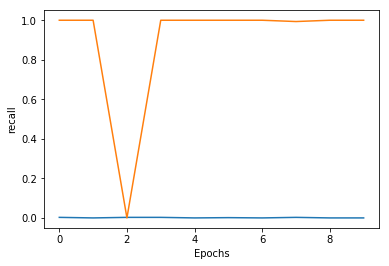

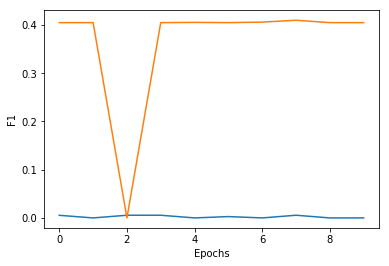

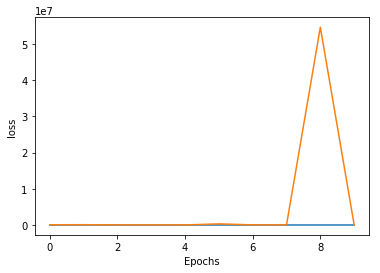

Epoch 11/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:38<00:00,  1.71s/it, loss=0.360]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.325


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.270 ; Confusion_Matrix: 0.270 ; loss: 7734.319


precision: 0.257 ; recall: 1.000 ; F1: 0.409 ; accuracy: 0.267


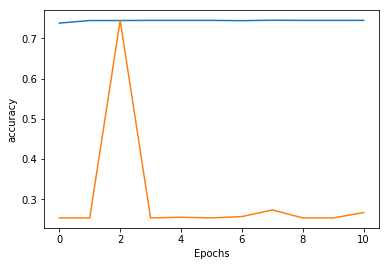

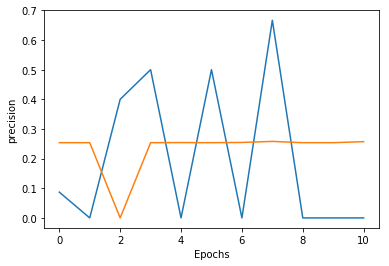

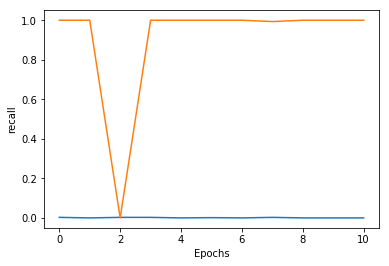

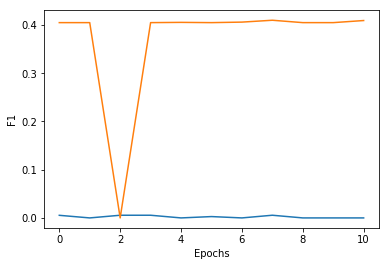

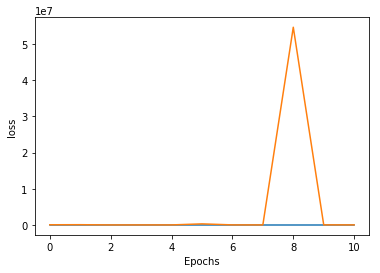

Epoch 12/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:29<00:00,  1.62s/it, loss=0.357]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.301


precision: 0.500 ; recall: 0.001 ; F1: 0.003 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 15135.727


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


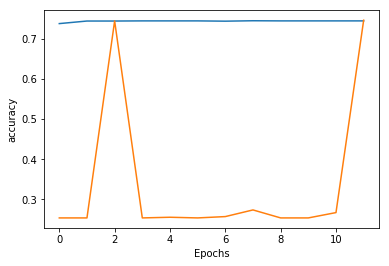

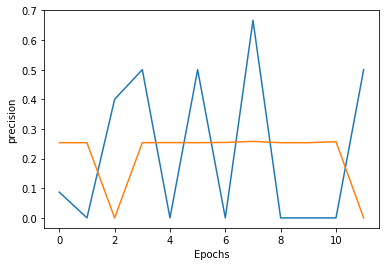

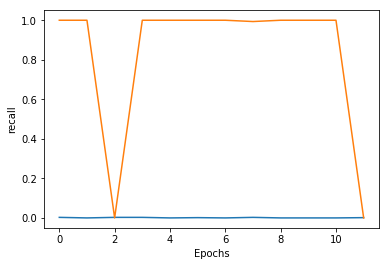

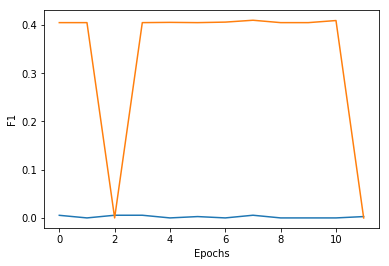

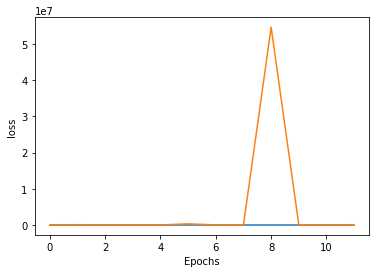

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 13/1000
100%|██████████| 352/352 [10:30<00:00,  1.72s/it, loss=0.357]
- Train metrics: accuracy: 0.844 ; Confusion_Matrix: 0.844 ; loss: 0.243


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.260 ; Confusion_Matrix: 0.260 ; loss: 8154.209


precision: 0.255 ; recall: 1.000 ; F1: 0.406 ; accuracy: 0.257


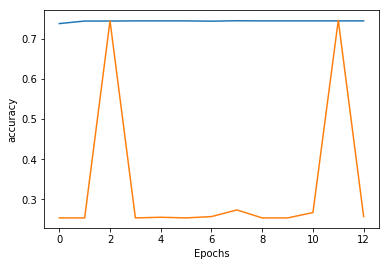

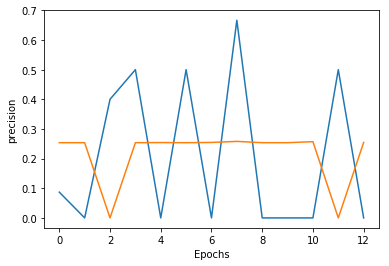

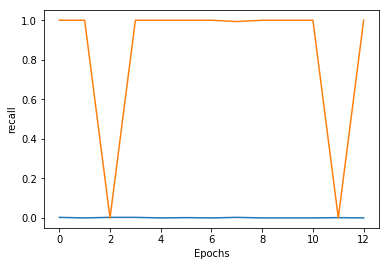

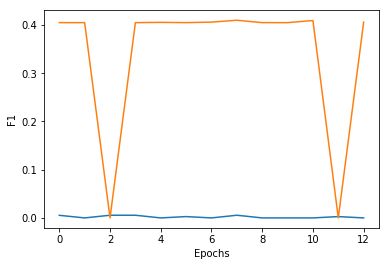

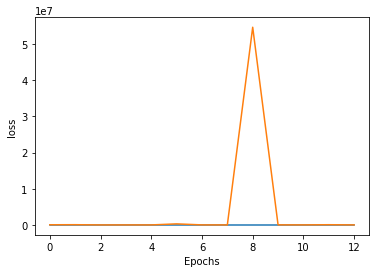

Epoch 14/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:28<00:00,  1.83s/it, loss=0.357]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.396


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 184.673


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


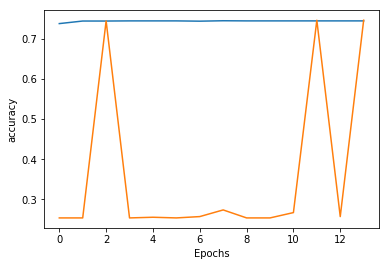

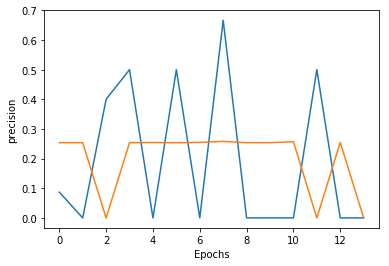

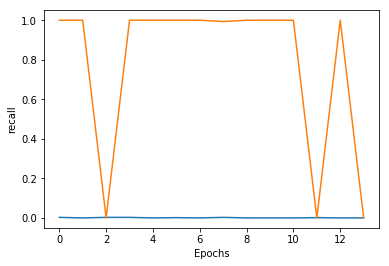

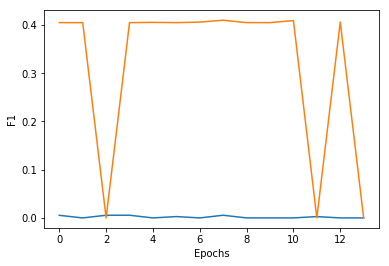

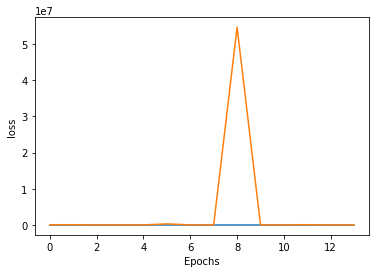

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 15/1000
100%|██████████| 352/352 [10:29<00:00,  1.65s/it, loss=0.356]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.300


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 5639.207


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


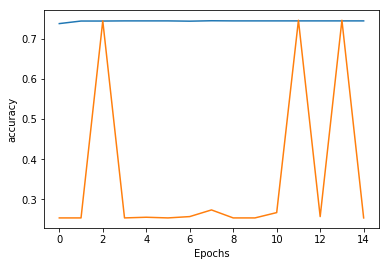

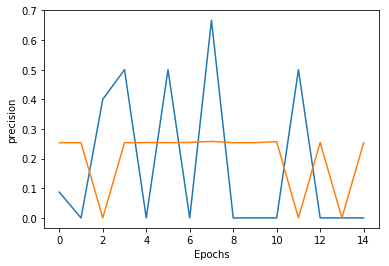

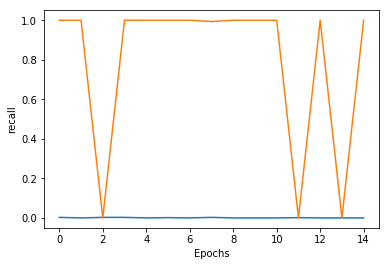

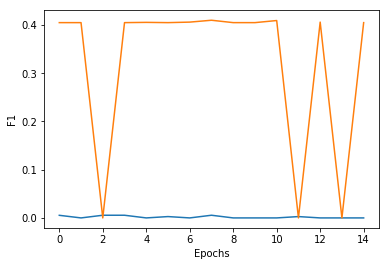

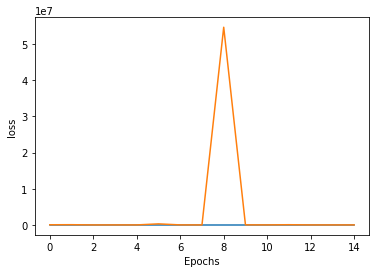

Epoch 16/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:20<00:00,  1.80s/it, loss=0.362]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.484


precision: 0.500 ; recall: 0.001 ; F1: 0.003 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 1.244


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


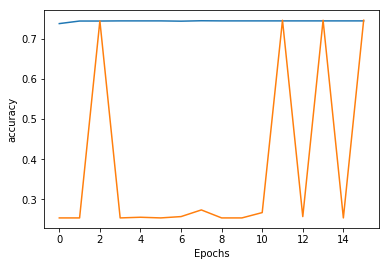

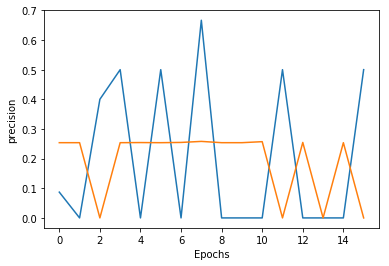

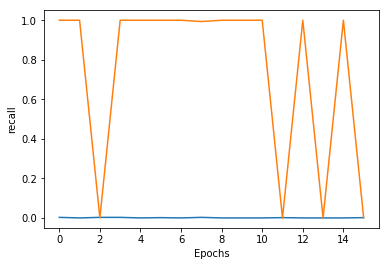

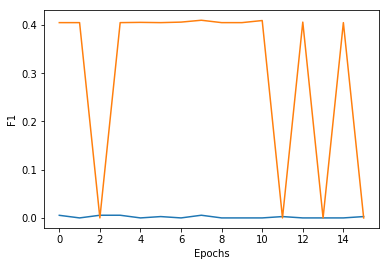

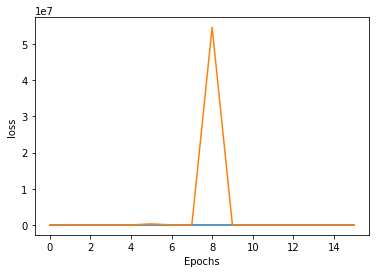

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 17/1000
100%|██████████| 352/352 [10:23<00:00,  1.81s/it, loss=0.353]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.254


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.269 ; Confusion_Matrix: 0.269 ; loss: 135.135


precision: 0.257 ; recall: 1.000 ; F1: 0.409 ; accuracy: 0.265


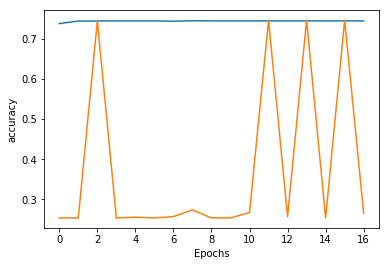

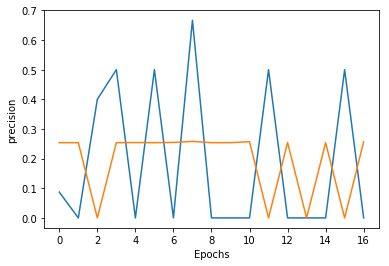

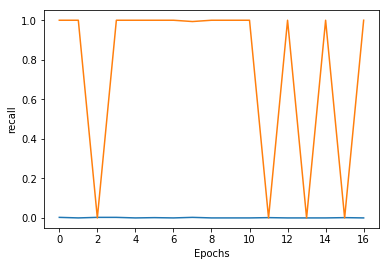

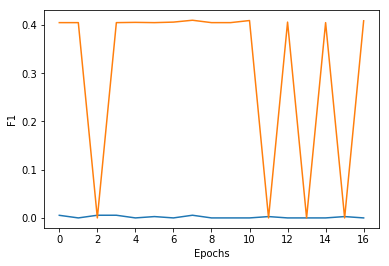

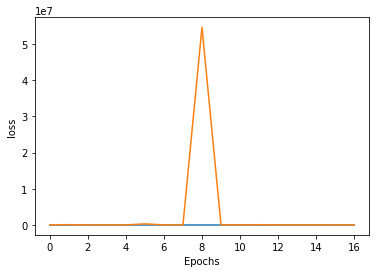

Epoch 18/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:29<00:00,  1.79s/it, loss=0.353]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.351


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.280 ; Confusion_Matrix: 0.280 ; loss: 102.821


precision: 0.255 ; recall: 0.961 ; F1: 0.403 ; accuracy: 0.277


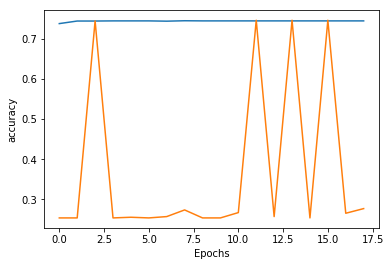

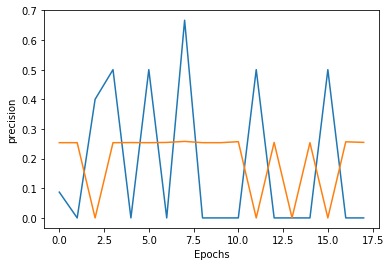

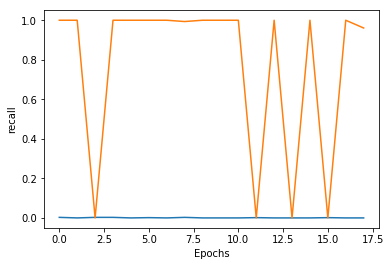

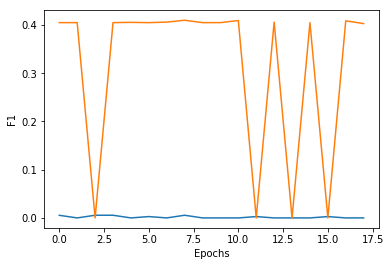

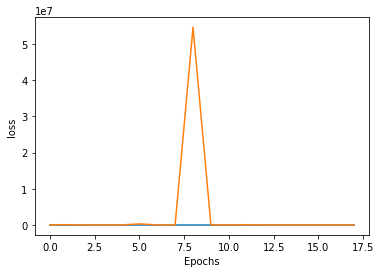

Epoch 19/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:21<00:00,  1.78s/it, loss=0.363]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.479


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 324.794


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


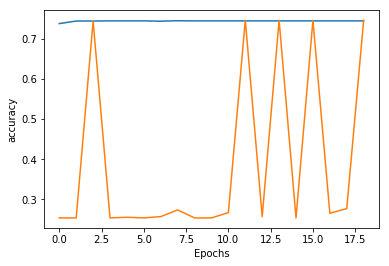

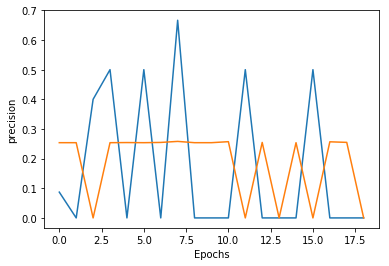

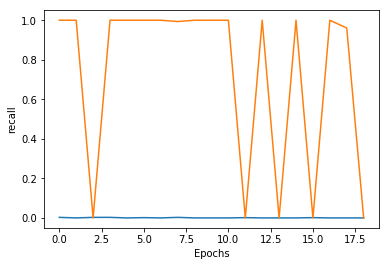

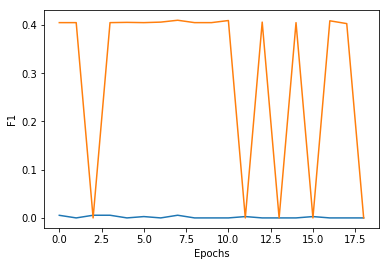

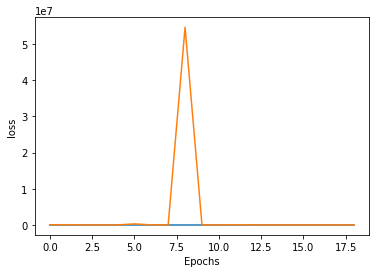

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 20/1000
100%|██████████| 352/352 [10:23<00:00,  1.69s/it, loss=0.354]
- Train metrics: accuracy: 0.625 ; Confusion_Matrix: 0.625 ; loss: 0.468


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 0.757


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


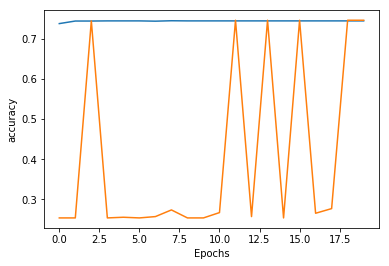

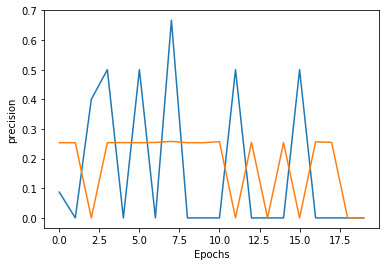

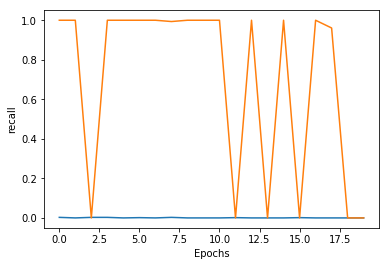

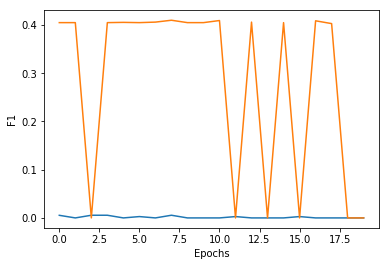

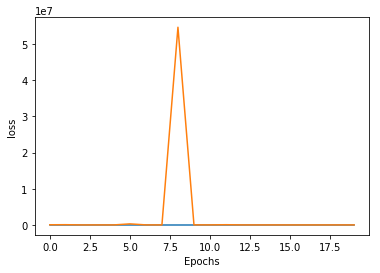

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 21/1000
100%|██████████| 352/352 [10:19<00:00,  1.53s/it, loss=0.360]
- Train metrics: accuracy: 0.594 ; Confusion_Matrix: 0.594 ; loss: 0.517


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.744


- Eval metrics : accuracy: 0.537 ; Confusion_Matrix: 0.537 ; loss: 6.235


precision: 0.238 ; recall: 0.373 ; F1: 0.291 ; accuracy: 0.539


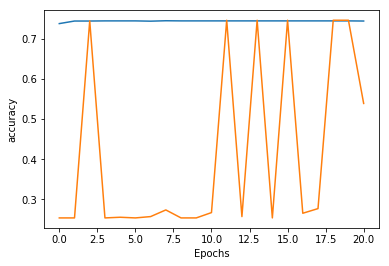

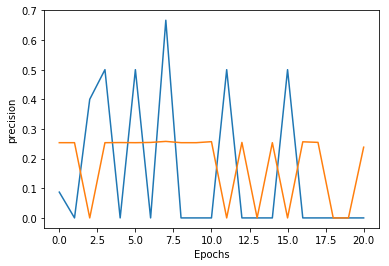

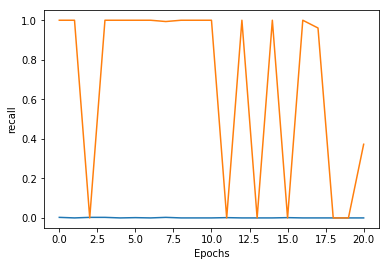

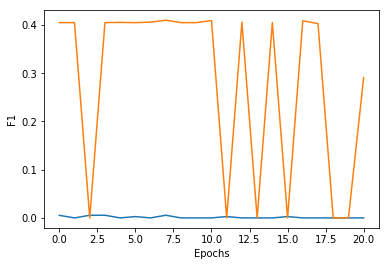

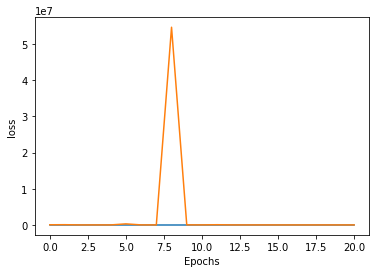

Epoch 22/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:16<00:00,  1.68s/it, loss=0.353]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.375


precision: 0.250 ; recall: 0.001 ; F1: 0.003 ; accuracy: 0.744


- Eval metrics : accuracy: 0.444 ; Confusion_Matrix: 0.444 ; loss: 9.176


precision: 0.227 ; recall: 0.503 ; F1: 0.313 ; accuracy: 0.439


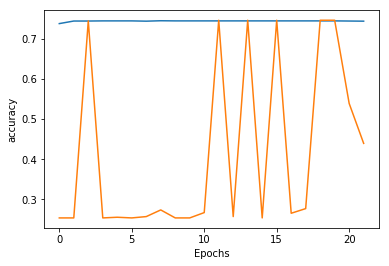

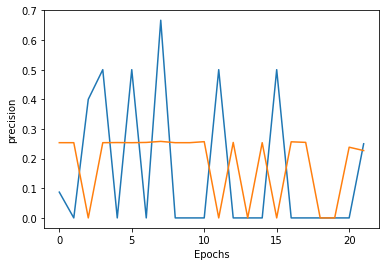

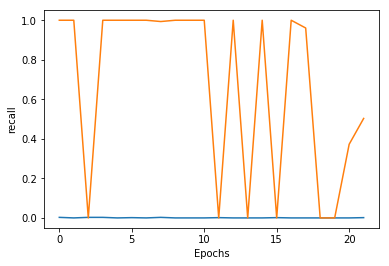

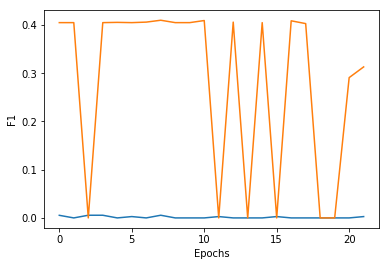

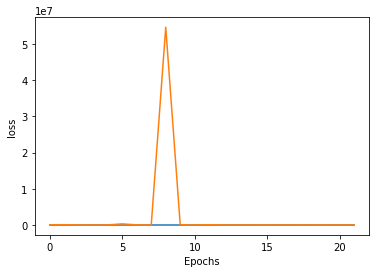

Epoch 23/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:26<00:00,  1.80s/it, loss=0.355]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.310


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 23649864.829


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


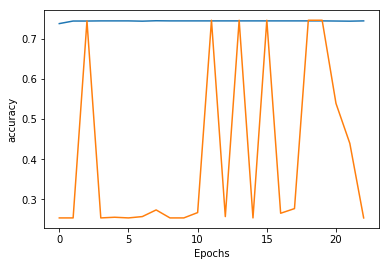

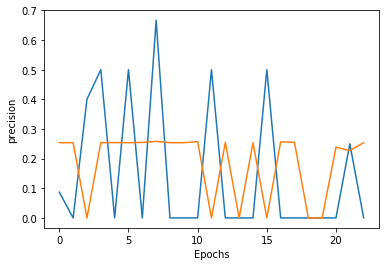

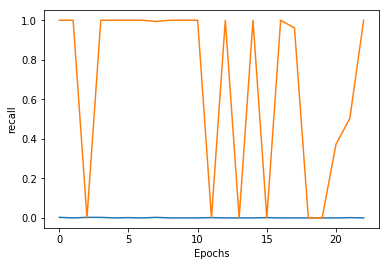

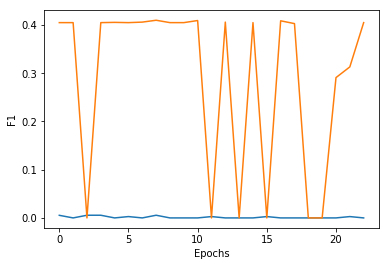

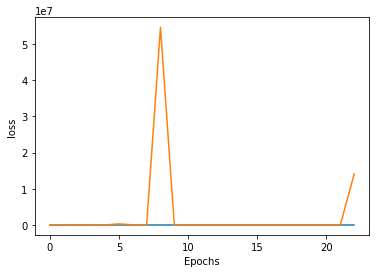

Epoch 24/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:16<00:00,  1.61s/it, loss=0.356]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.279


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 446.986


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


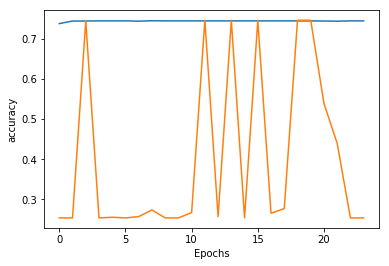

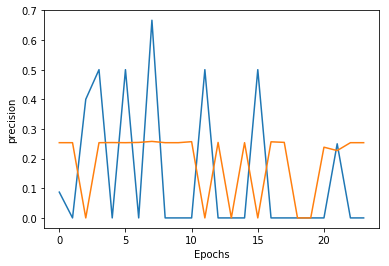

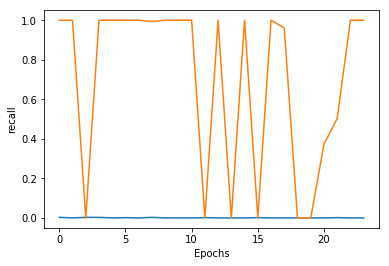

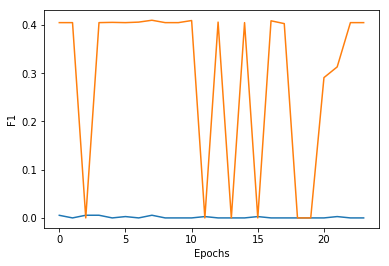

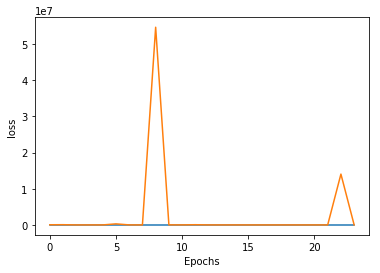

Epoch 25/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:12<00:00,  1.83s/it, loss=0.354]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.455


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.264 ; Confusion_Matrix: 0.264 ; loss: 4287.352


precision: 0.255 ; recall: 1.000 ; F1: 0.407 ; accuracy: 0.260


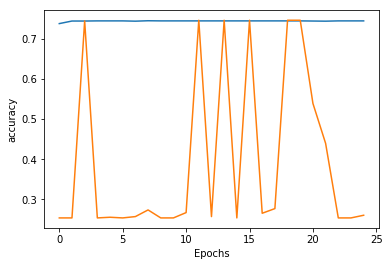

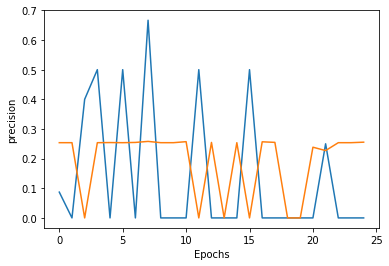

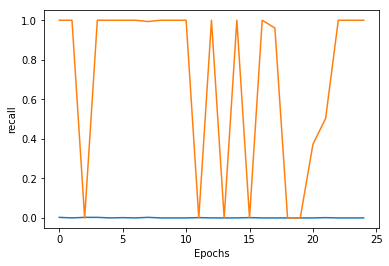

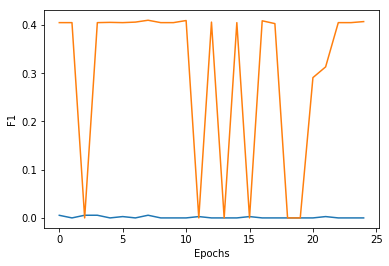

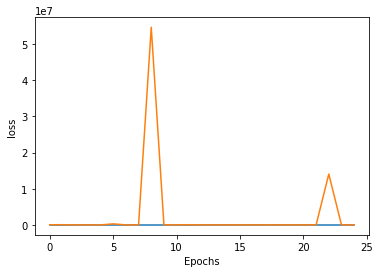

Epoch 26/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:20<00:00,  1.68s/it, loss=0.354]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.300


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 2693.705


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


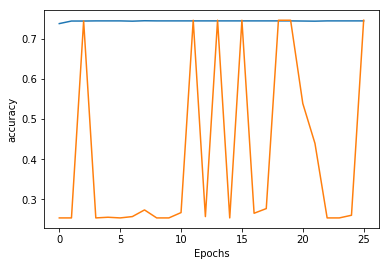

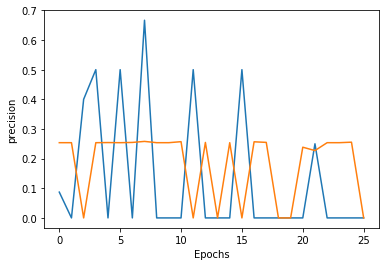

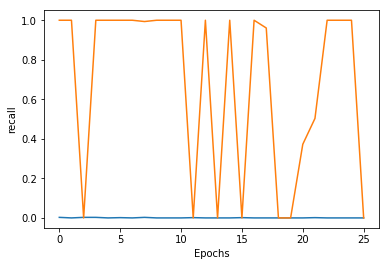

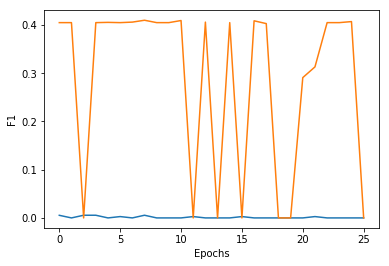

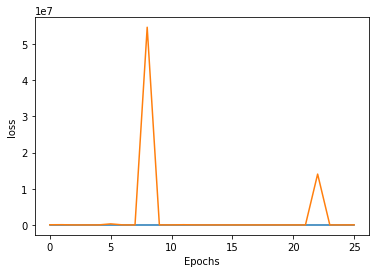

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 27/1000
100%|██████████| 352/352 [10:12<00:00,  1.62s/it, loss=0.357]
- Train metrics: accuracy: 0.594 ; Confusion_Matrix: 0.594 ; loss: 0.611


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 173.910


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


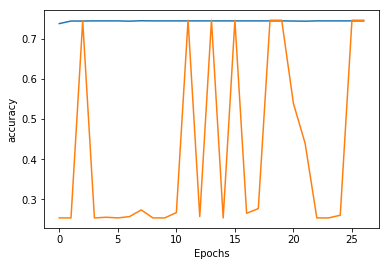

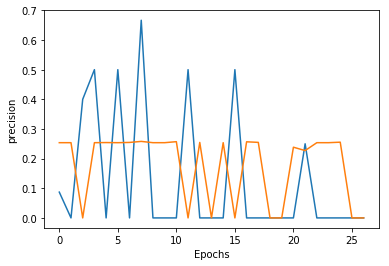

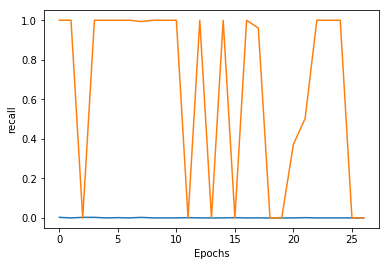

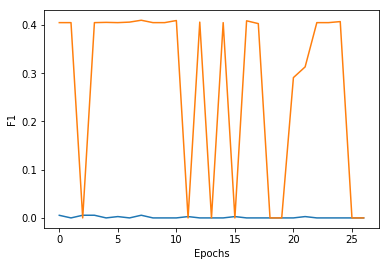

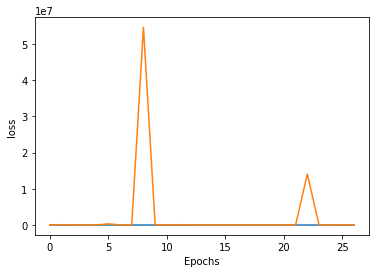

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 28/1000
100%|██████████| 352/352 [10:12<00:00,  1.88s/it, loss=0.355]
- Train metrics: accuracy: 0.625 ; Confusion_Matrix: 0.625 ; loss: 0.497


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 2411.221


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


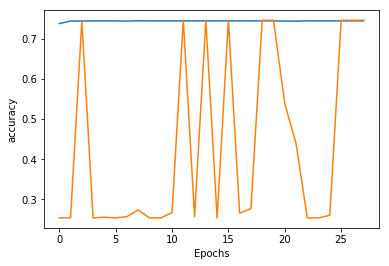

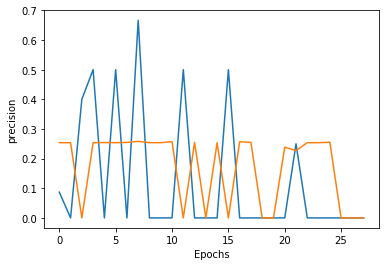

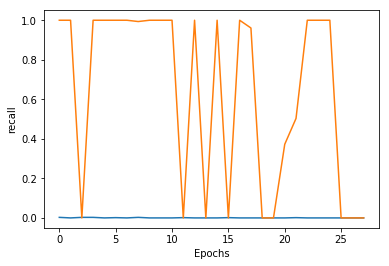

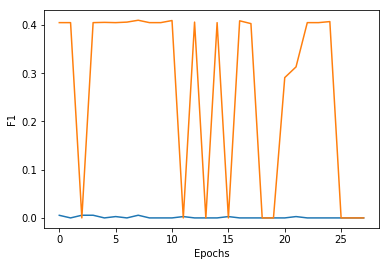

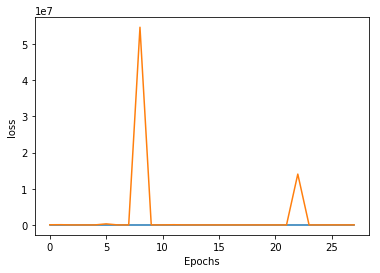

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 29/1000
100%|██████████| 352/352 [10:20<00:00,  1.51s/it, loss=0.350]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.400


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 6231.708


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


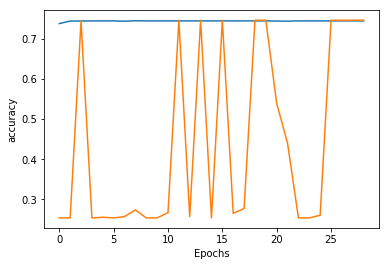

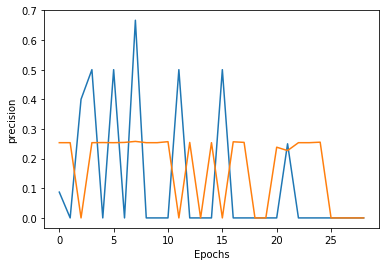

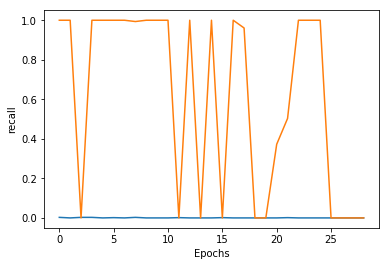

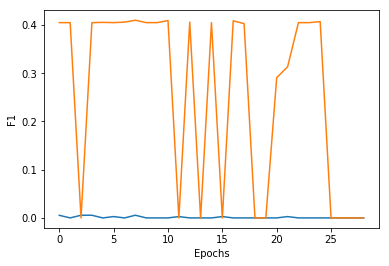

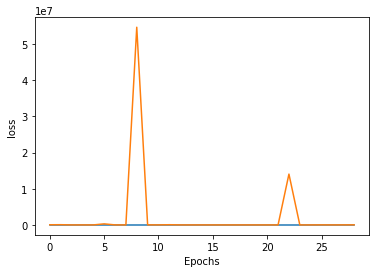

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 30/1000
100%|██████████| 352/352 [10:13<00:00,  1.68s/it, loss=0.352]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.278


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 29055.140


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


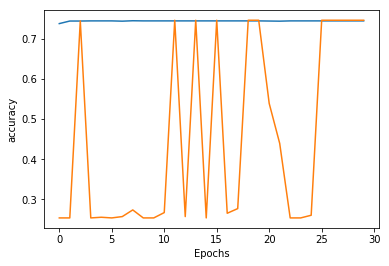

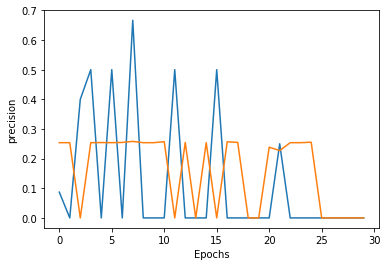

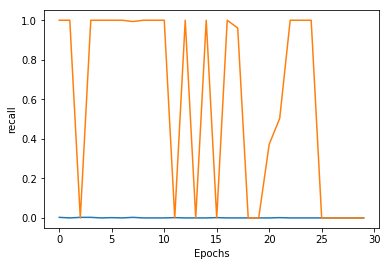

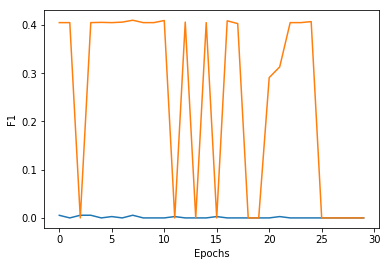

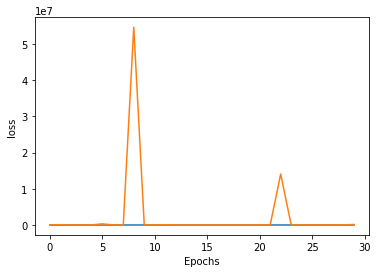

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 31/1000
100%|██████████| 352/352 [10:23<00:00,  1.74s/it, loss=0.351]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.356


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 879.937


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


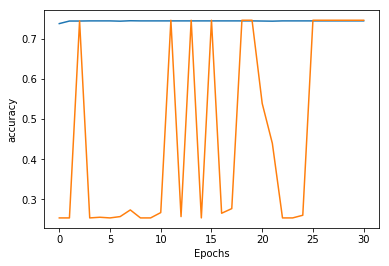

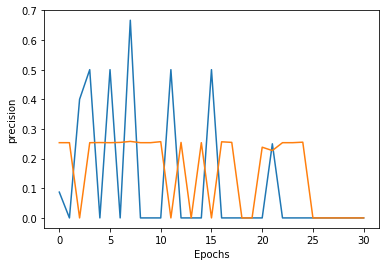

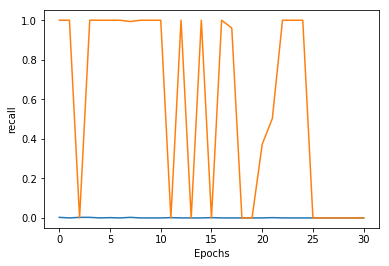

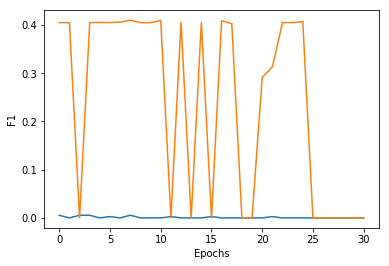

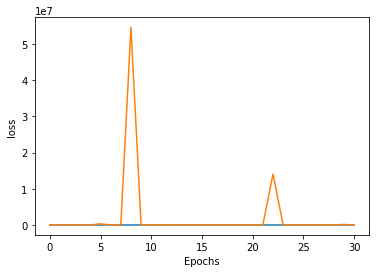

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 32/1000
100%|██████████| 352/352 [10:18<00:00,  1.49s/it, loss=0.352]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.268


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.264 ; Confusion_Matrix: 0.264 ; loss: 1353.118


precision: 0.255 ; recall: 1.000 ; F1: 0.407 ; accuracy: 0.260


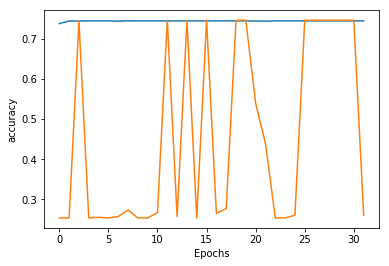

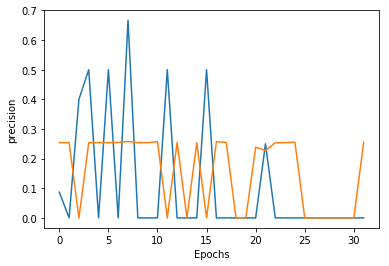

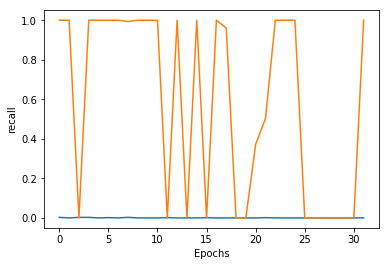

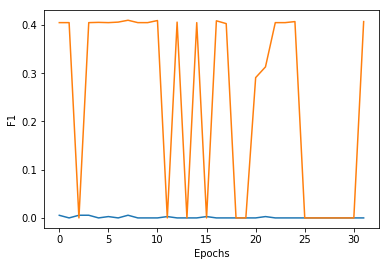

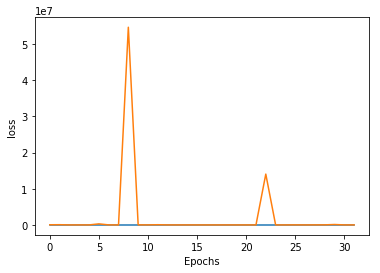

Epoch 33/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:19<00:00,  1.59s/it, loss=0.351]
- Train metrics: accuracy: 0.844 ; Confusion_Matrix: 0.844 ; loss: 0.271


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 2.057


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


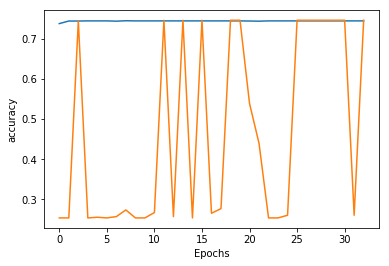

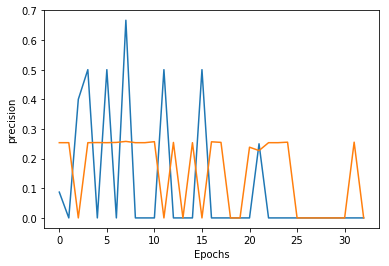

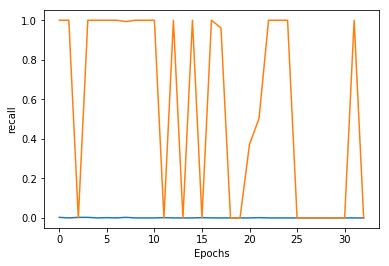

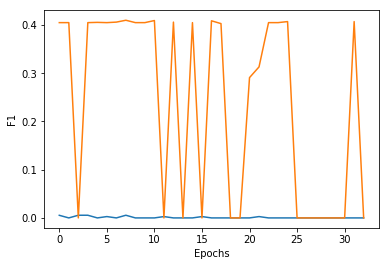

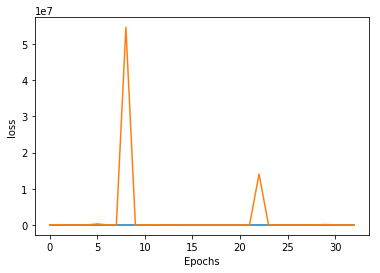

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 34/1000
100%|██████████| 352/352 [10:18<00:00,  1.52s/it, loss=0.357]
- Train metrics: accuracy: 0.844 ; Confusion_Matrix: 0.844 ; loss: 0.243


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.740 ; Confusion_Matrix: 0.740 ; loss: 14.470


precision: 0.417 ; recall: 0.033 ; F1: 0.061 ; accuracy: 0.743


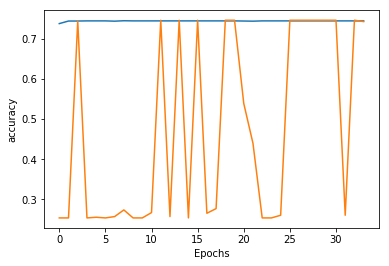

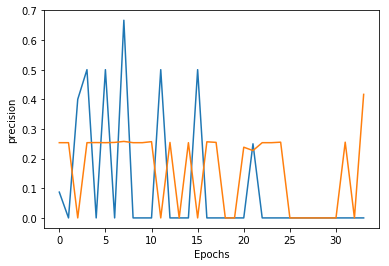

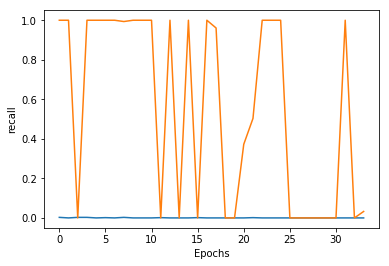

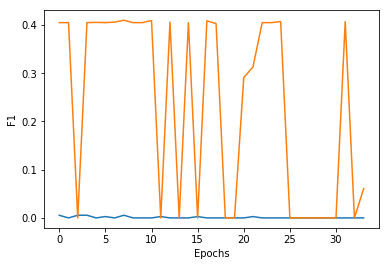

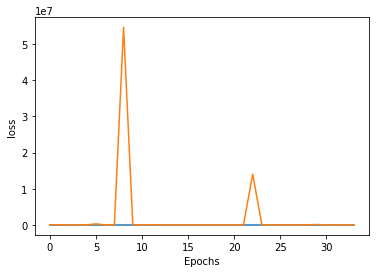

Epoch 35/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:23<00:00,  1.78s/it, loss=0.357]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.384


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 6677965.941


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


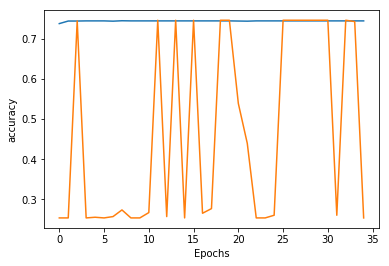

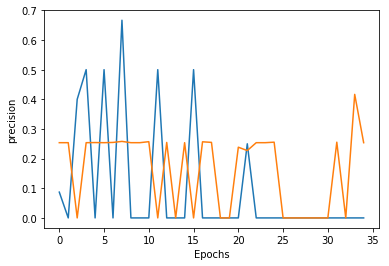

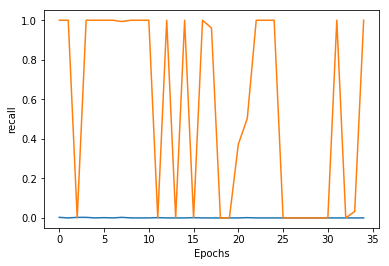

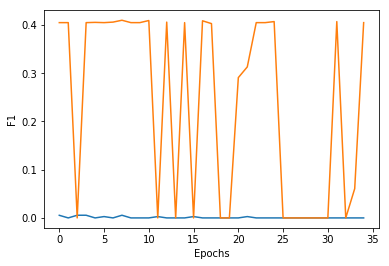

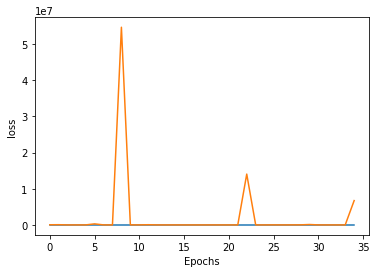

Epoch 36/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:16<00:00,  1.60s/it, loss=0.353]
- Train metrics: accuracy: 0.844 ; Confusion_Matrix: 0.844 ; loss: 0.237


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 69.014


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


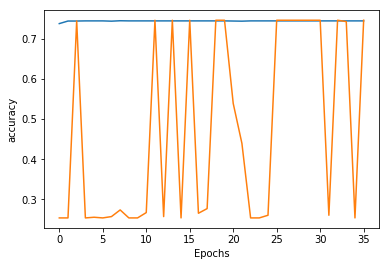

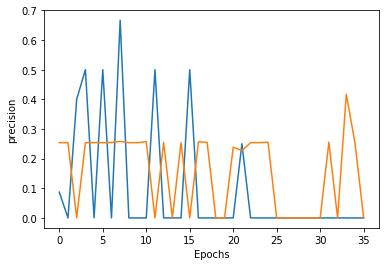

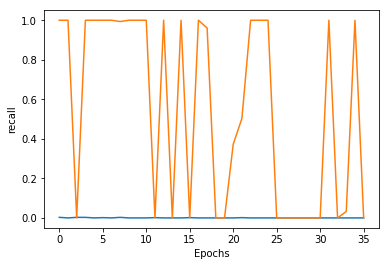

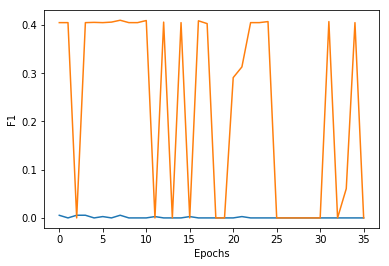

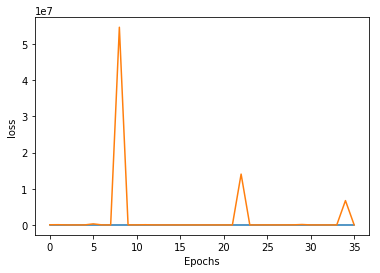

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 37/1000
100%|██████████| 352/352 [10:24<00:00,  1.61s/it, loss=0.352]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.290


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.259 ; Confusion_Matrix: 0.259 ; loss: 62729.130


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.255


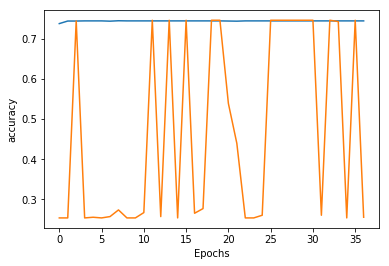

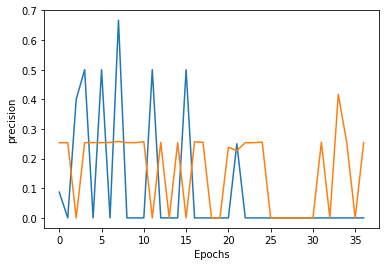

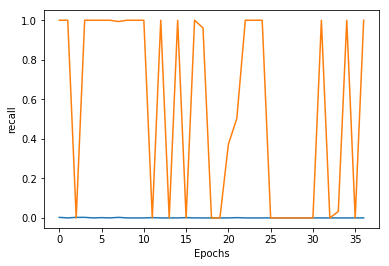

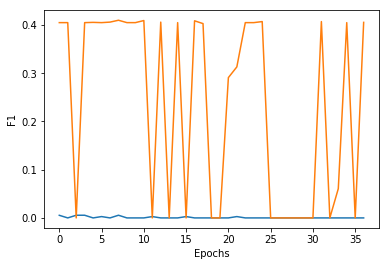

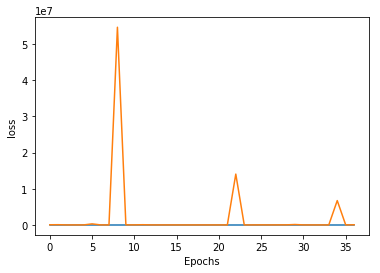

Epoch 38/1000


Checkpoint Directory exists! 


100%|██████████| 352/352 [10:16<00:00,  1.76s/it, loss=0.352]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.299


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 2685002.425


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


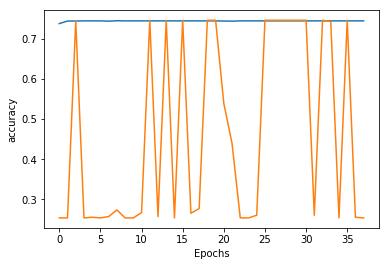

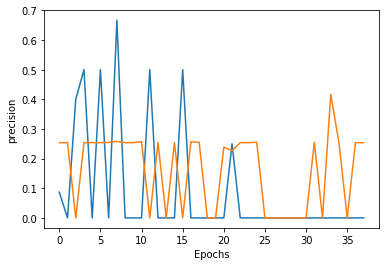

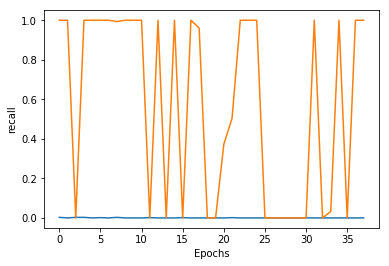

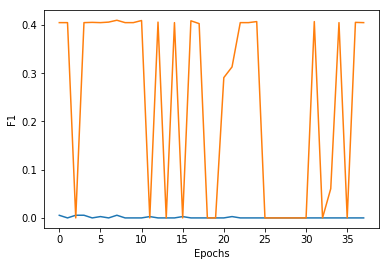

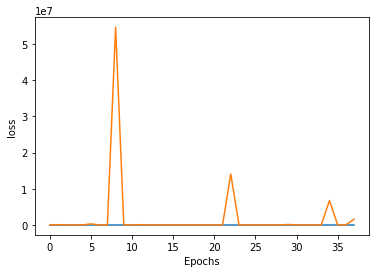

Epoch 39/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:21<00:00,  1.69s/it, loss=0.348]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.361


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 804.517


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


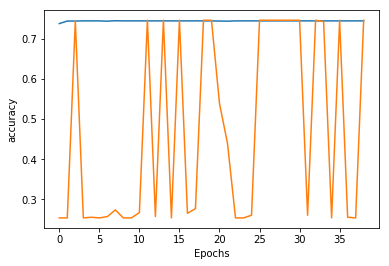

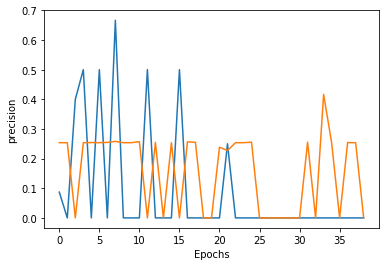

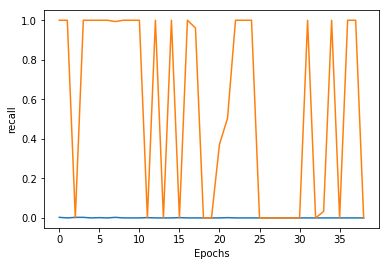

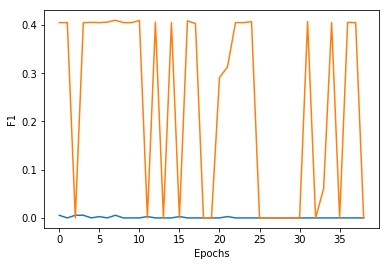

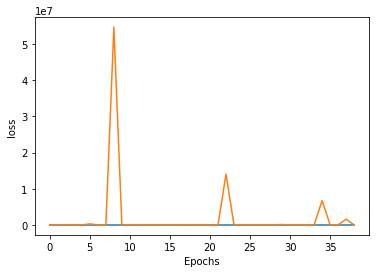

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 40/1000
100%|██████████| 352/352 [10:15<00:00,  1.72s/it, loss=0.356]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.412


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 207.015


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


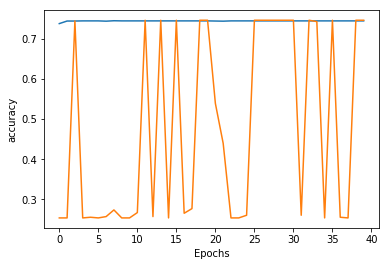

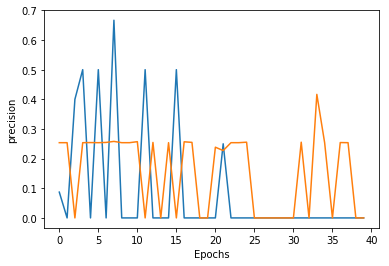

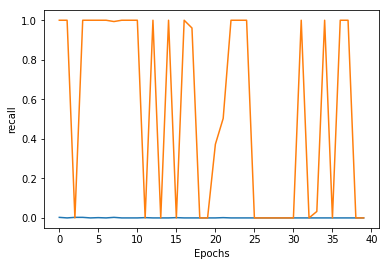

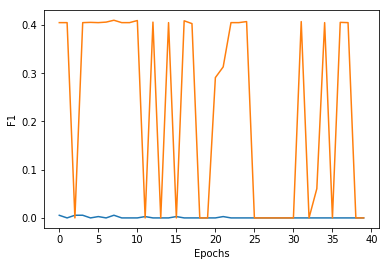

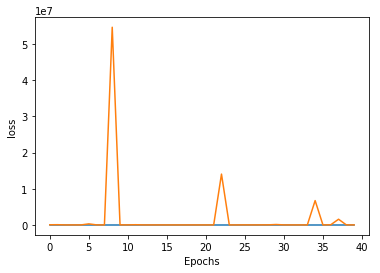

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 41/1000
100%|██████████| 352/352 [10:26<00:00,  1.92s/it, loss=0.351]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.442


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 364110.795


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


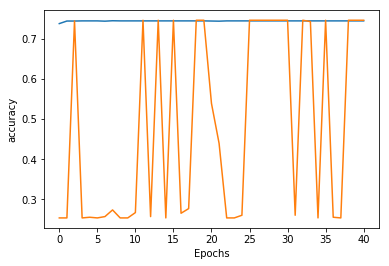

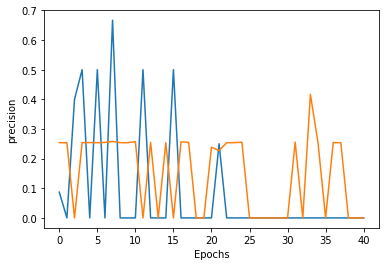

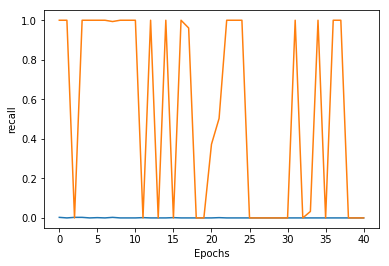

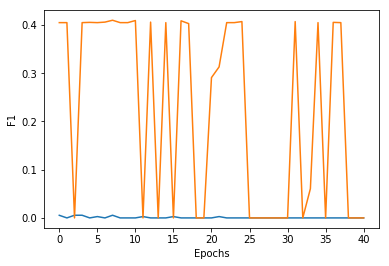

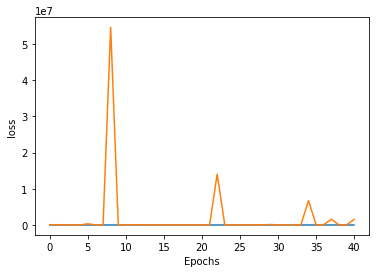

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 42/1000
100%|██████████| 352/352 [10:26<00:00,  1.74s/it, loss=0.354]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.309


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 277813.441


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


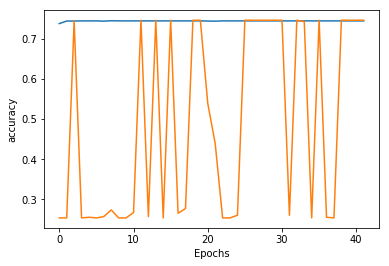

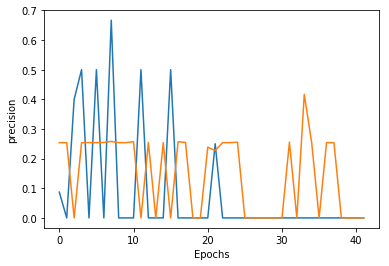

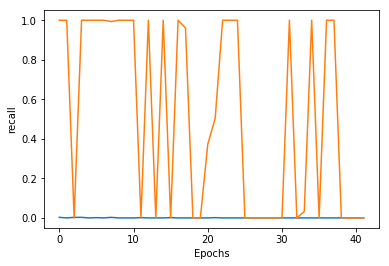

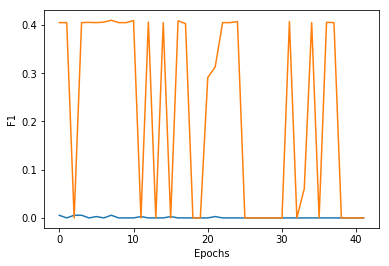

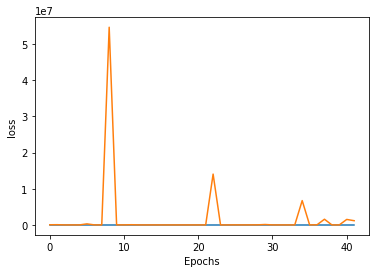

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 43/1000
100%|██████████| 352/352 [10:08<00:00,  1.70s/it, loss=0.350]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.435


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 43788.462


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


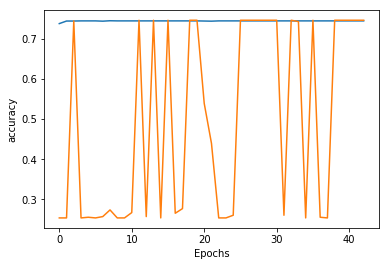

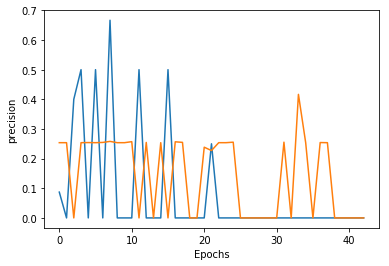

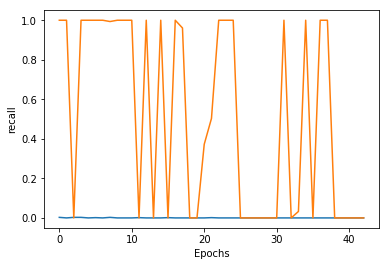

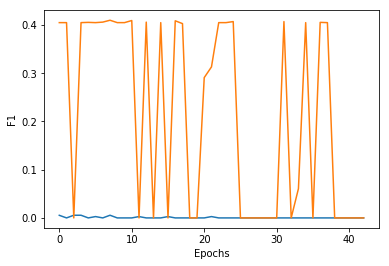

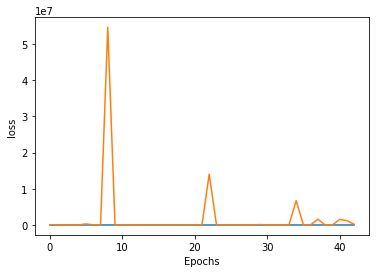

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 44/1000
100%|██████████| 352/352 [10:17<00:00,  1.67s/it, loss=0.351]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.346


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 437644.779


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


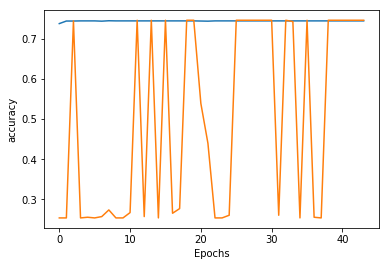

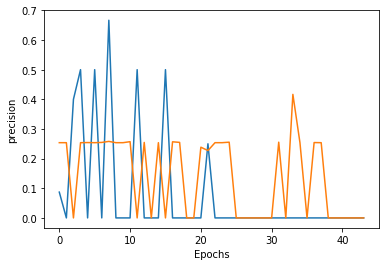

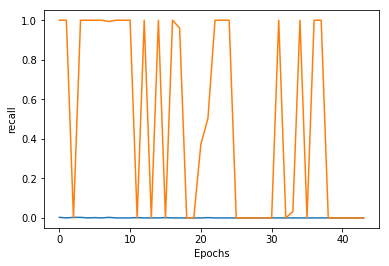

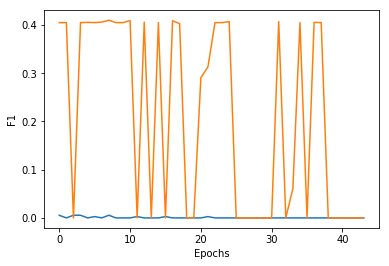

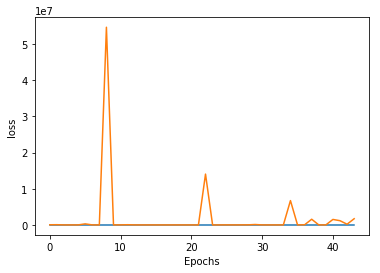

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 45/1000
100%|██████████| 352/352 [10:20<00:00,  1.68s/it, loss=0.349]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.379


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 2024.699


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


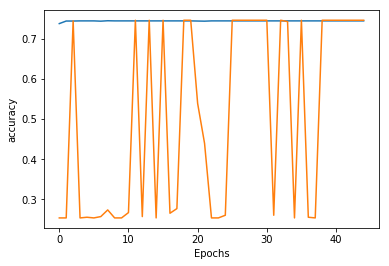

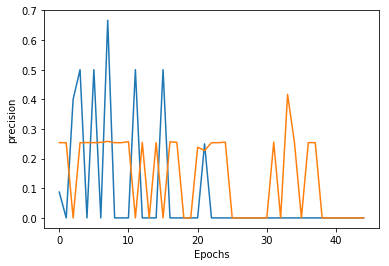

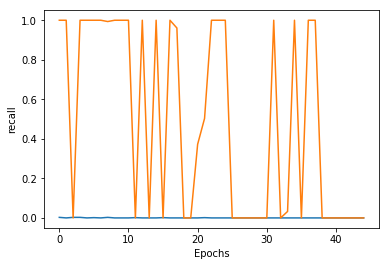

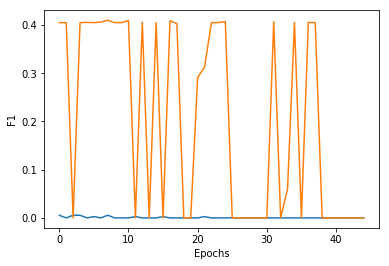

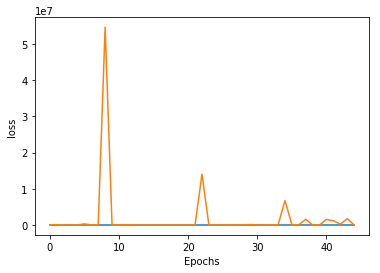

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 46/1000
100%|██████████| 352/352 [10:18<00:00,  1.70s/it, loss=0.348]
- Train metrics: accuracy: 0.594 ; Confusion_Matrix: 0.594 ; loss: 0.506


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.320 ; Confusion_Matrix: 0.320 ; loss: 6129.102


precision: 0.254 ; recall: 0.876 ; F1: 0.394 ; accuracy: 0.317


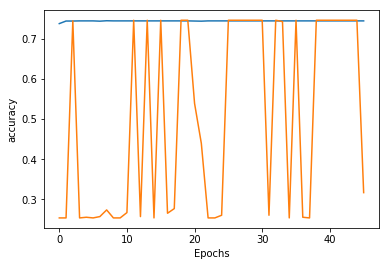

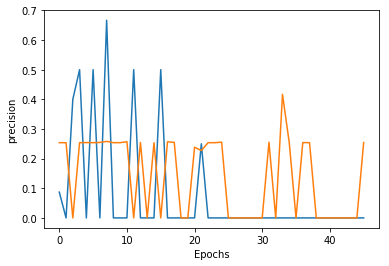

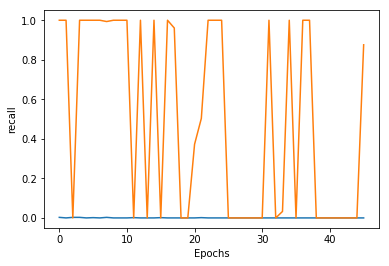

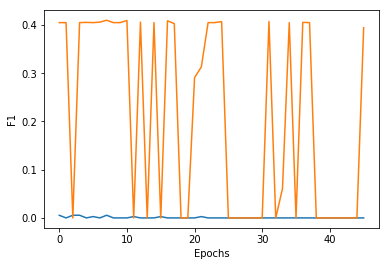

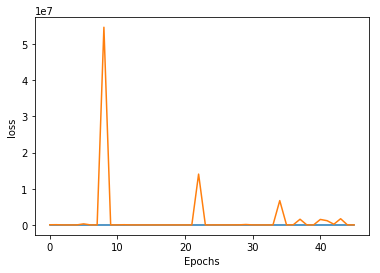

Epoch 47/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:16<00:00,  1.78s/it, loss=0.347]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.384


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.264 ; Confusion_Matrix: 0.264 ; loss: 341437.627


precision: 0.255 ; recall: 1.000 ; F1: 0.407 ; accuracy: 0.260


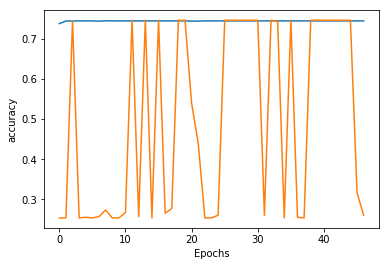

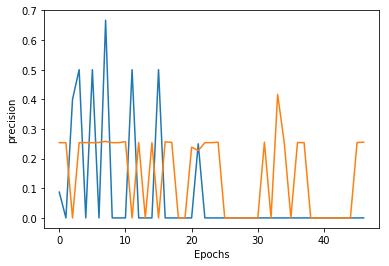

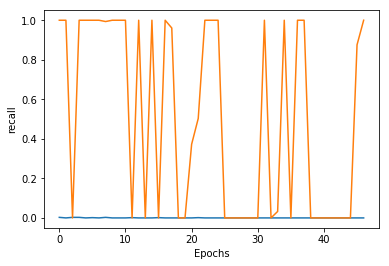

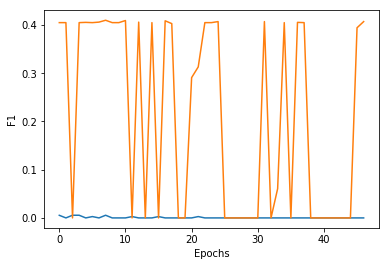

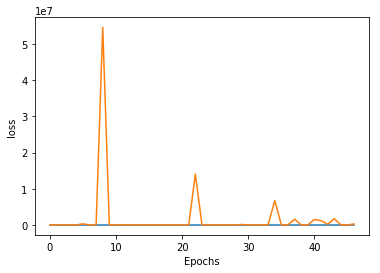

Epoch 48/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:24<00:00,  1.61s/it, loss=0.350]
- Train metrics: accuracy: 0.688 ; Confusion_Matrix: 0.688 ; loss: 0.420


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 22947.146


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


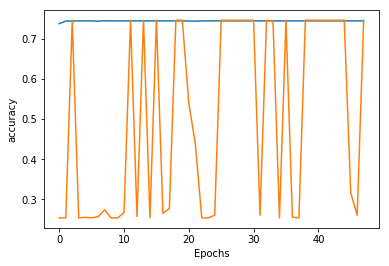

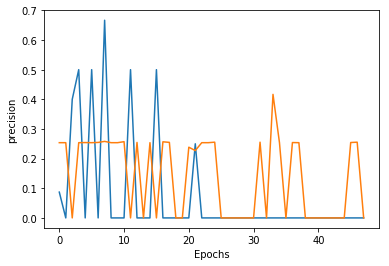

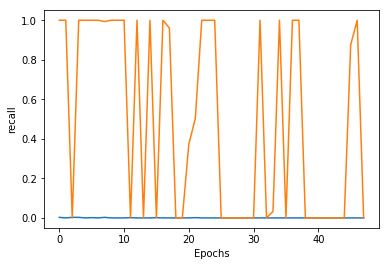

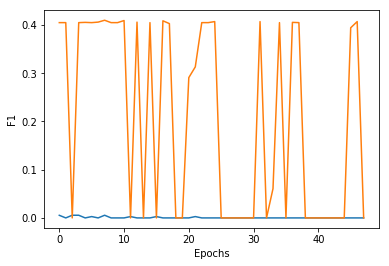

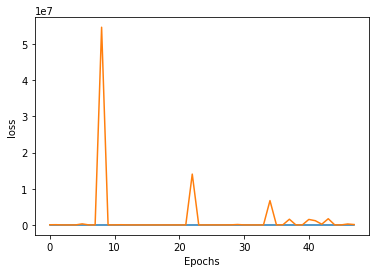

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 49/1000
100%|██████████| 352/352 [10:20<00:00,  1.67s/it, loss=0.347]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.423


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 167.766


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


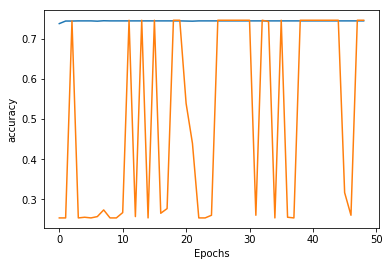

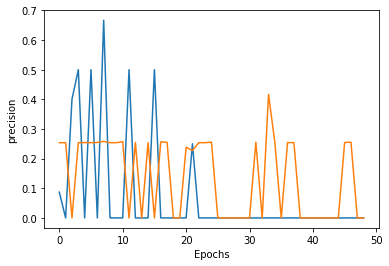

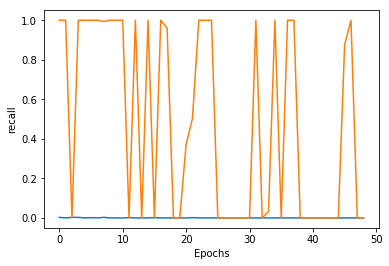

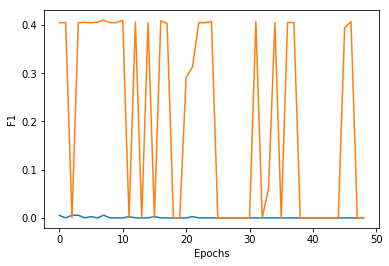

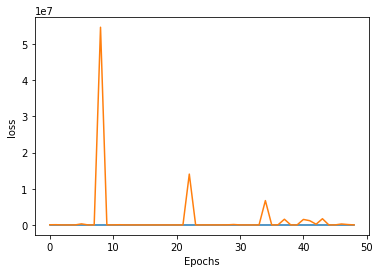

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 50/1000
100%|██████████| 352/352 [10:17<00:00,  1.80s/it, loss=0.347]
- Train metrics: accuracy: 0.844 ; Confusion_Matrix: 0.844 ; loss: 0.237


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 2322.470


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


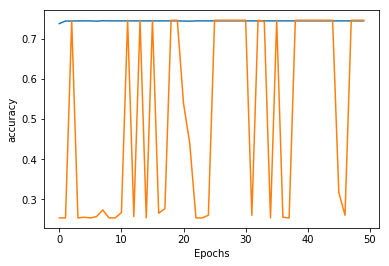

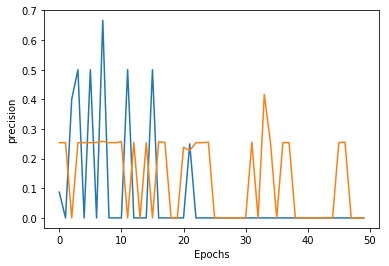

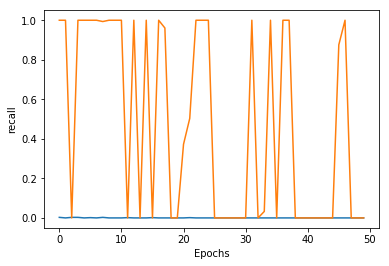

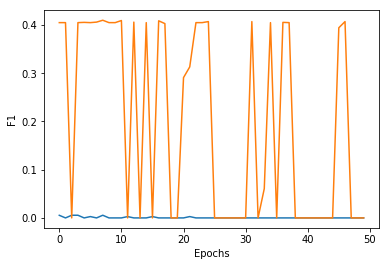

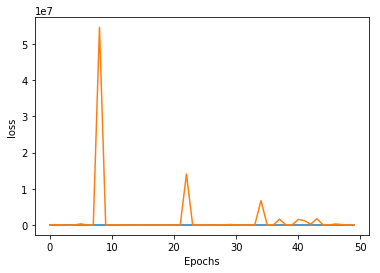

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 51/1000
100%|██████████| 352/352 [10:15<00:00,  1.44s/it, loss=0.350]
- Train metrics: accuracy: 0.688 ; Confusion_Matrix: 0.688 ; loss: 0.354


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 7099.432


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


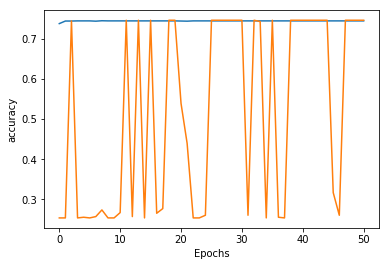

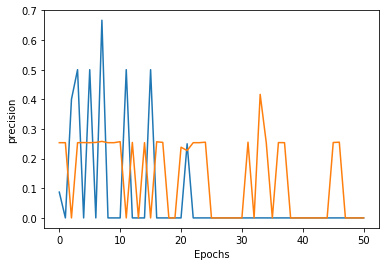

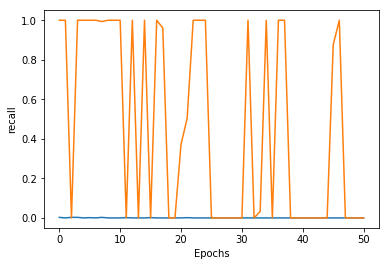

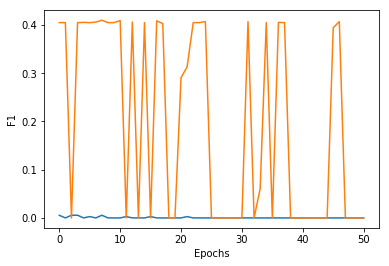

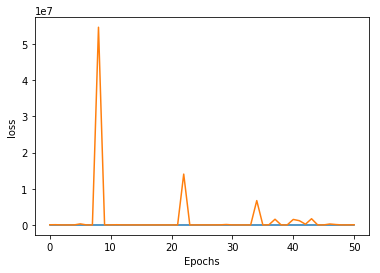

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 52/1000
100%|██████████| 352/352 [10:11<00:00,  1.76s/it, loss=0.345]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.372


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 2672.271


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


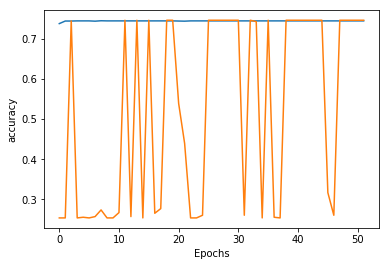

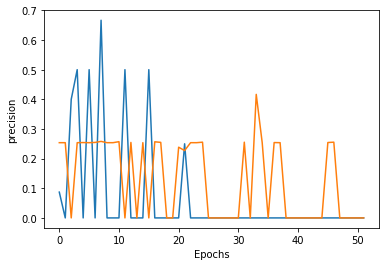

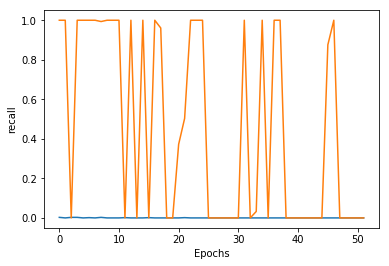

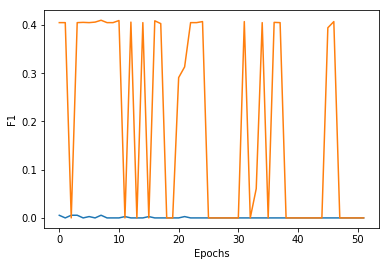

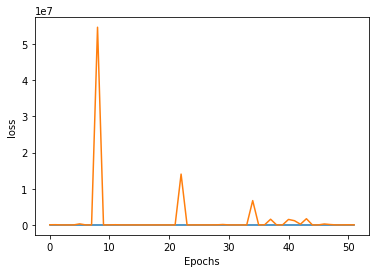

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 53/1000
100%|██████████| 352/352 [10:17<00:00,  1.75s/it, loss=0.346]
- Train metrics: accuracy: 0.688 ; Confusion_Matrix: 0.688 ; loss: 0.420


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.259 ; Confusion_Matrix: 0.259 ; loss: 490197.567


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.255


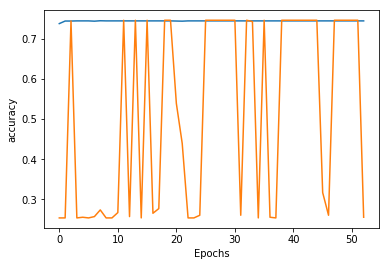

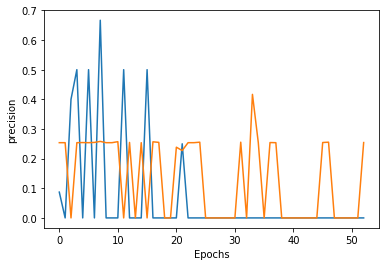

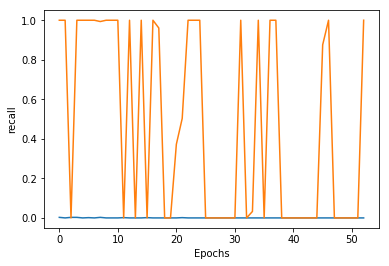

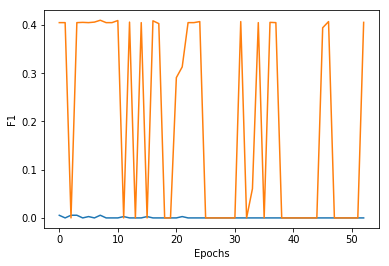

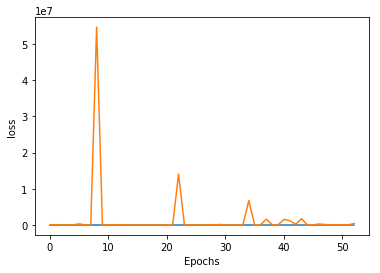

Epoch 54/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:10<00:00,  1.74s/it, loss=0.347]
- Train metrics: accuracy: 0.688 ; Confusion_Matrix: 0.688 ; loss: 0.402


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.272 ; Confusion_Matrix: 0.272 ; loss: 760.176


precision: 0.256 ; recall: 0.987 ; F1: 0.406 ; accuracy: 0.269


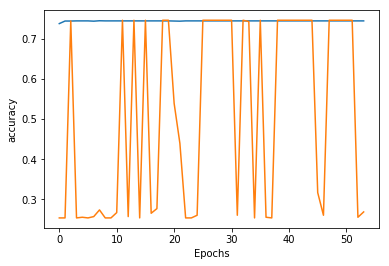

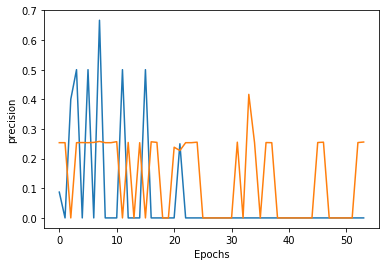

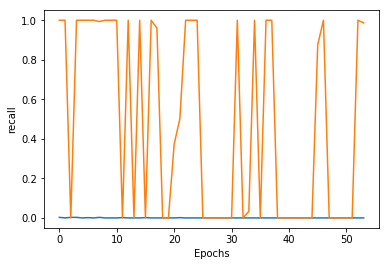

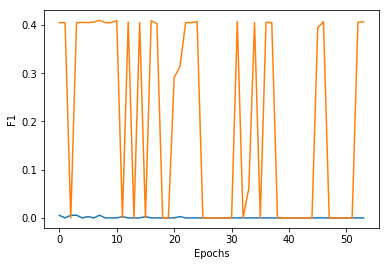

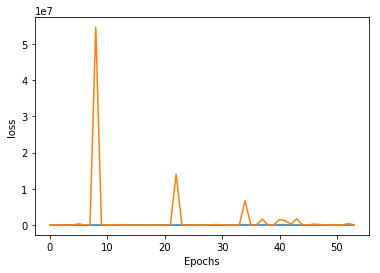

Epoch 55/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:15<00:00,  1.78s/it, loss=0.350]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.302


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 78414.647


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


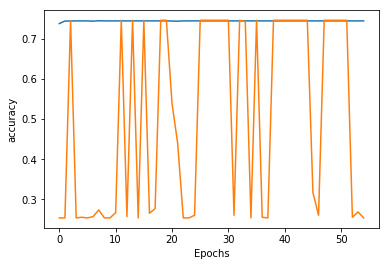

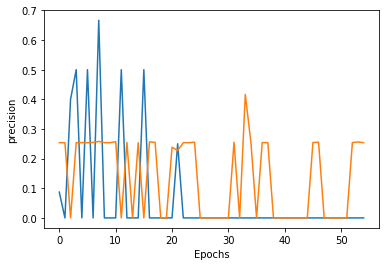

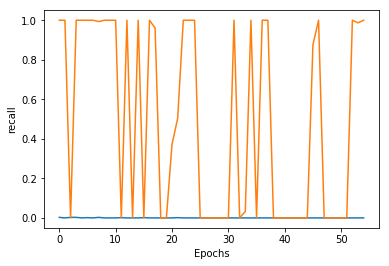

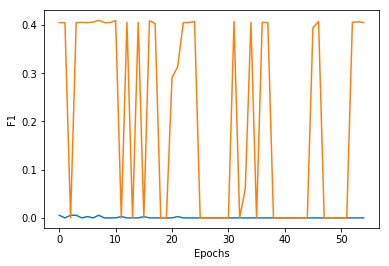

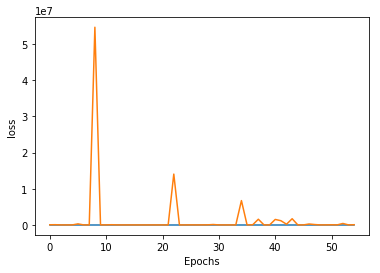

Epoch 56/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:21<00:00,  1.56s/it, loss=0.343]
- Train metrics: accuracy: 0.781 ; Confusion_Matrix: 0.781 ; loss: 0.302


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.513 ; Confusion_Matrix: 0.513 ; loss: 5.623


precision: 0.227 ; recall: 0.379 ; F1: 0.284 ; accuracy: 0.514


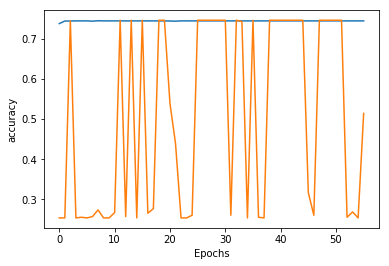

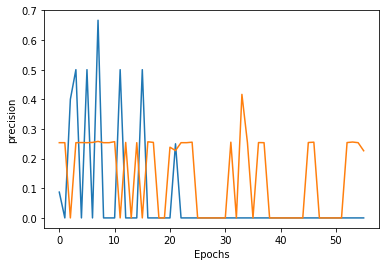

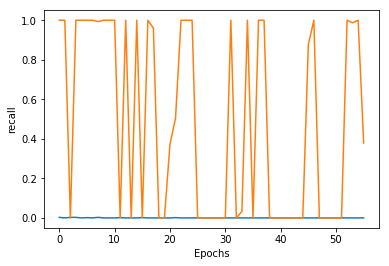

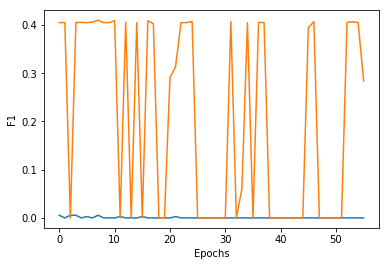

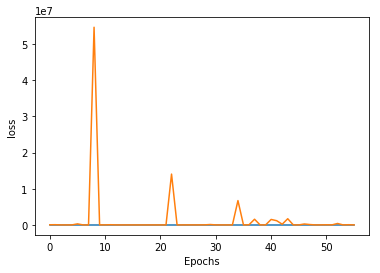

Epoch 57/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:22<00:00,  1.67s/it, loss=0.350]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.290


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.257 ; Confusion_Matrix: 0.257 ; loss: 264850.326


precision: 0.254 ; recall: 1.000 ; F1: 0.405 ; accuracy: 0.254


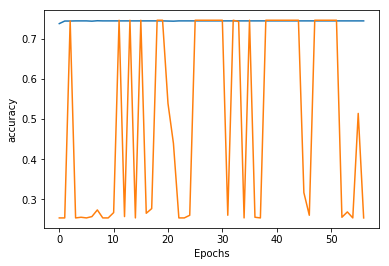

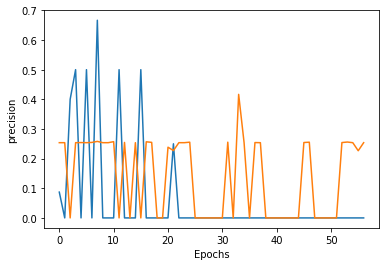

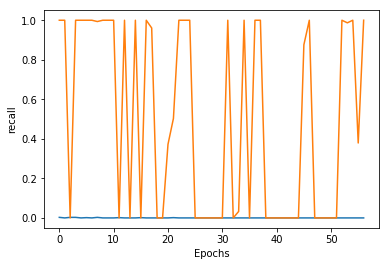

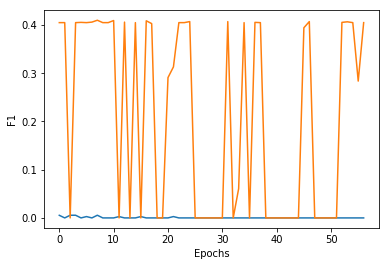

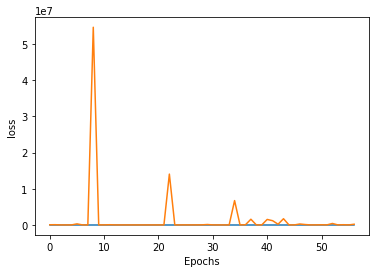

Epoch 58/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:21<00:00,  1.61s/it, loss=0.344]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.279


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 55675.233


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


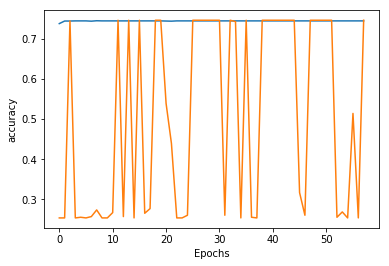

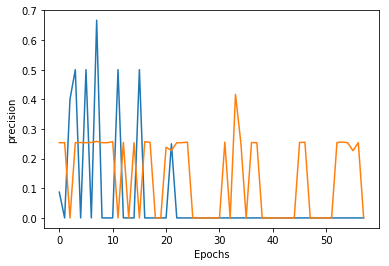

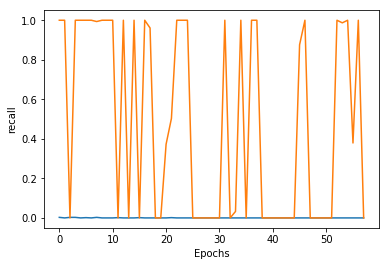

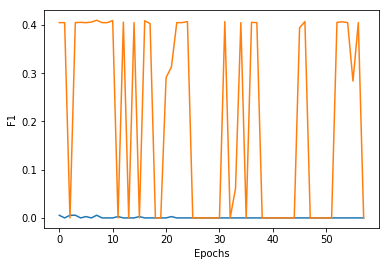

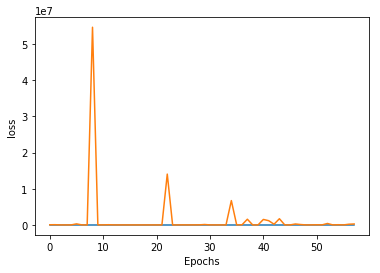

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 59/1000
100%|██████████| 352/352 [10:23<00:00,  1.75s/it, loss=0.346]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.311


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 210411.107


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


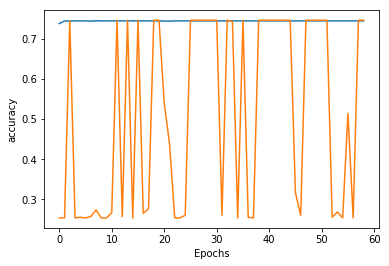

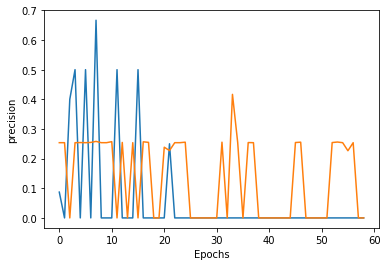

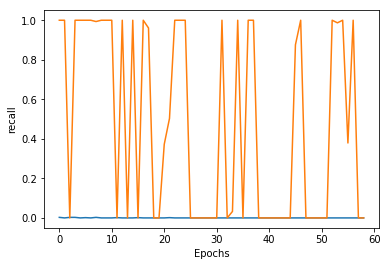

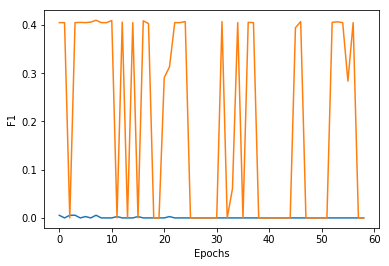

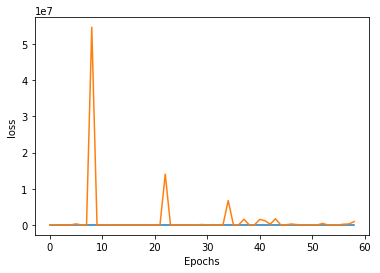

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 60/1000
100%|██████████| 352/352 [10:59<00:00,  1.70s/it, loss=0.341]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.337


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.260 ; Confusion_Matrix: 0.260 ; loss: 21584.740


precision: 0.255 ; recall: 1.000 ; F1: 0.406 ; accuracy: 0.257


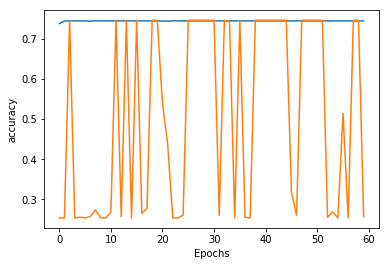

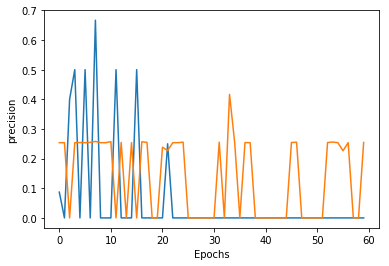

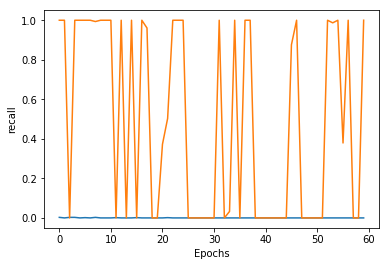

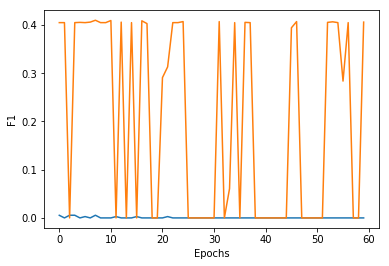

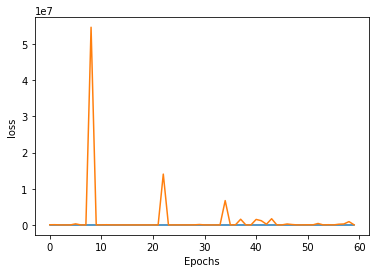

Epoch 61/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [10:21<00:00,  1.75s/it, loss=0.346]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.337


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 20360.375


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


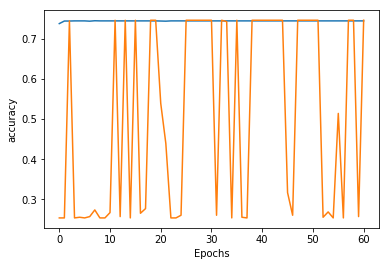

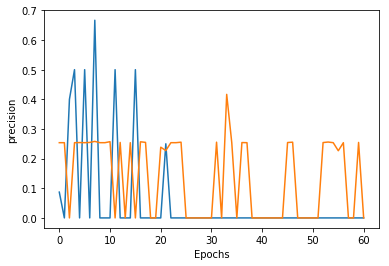

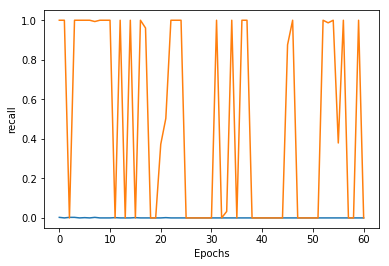

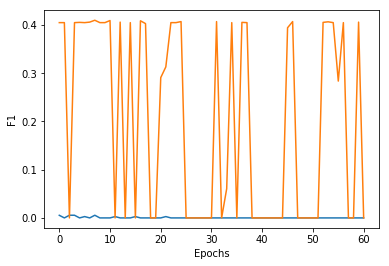

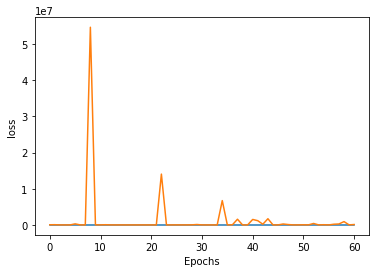

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 62/1000
 57%|█████▋    | 199/352 [06:27<05:07,  2.01s/it, loss=0.332]

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

# use GPU if available
params.cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(230)
if params.cuda: torch.cuda.manual_seed(230)

# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Create the input data pipeline
logging.info("Loading the datasets...")

# fetch dataloaders
dataloaders = data_loader.fetch_dataloader(['train', 'val'], data_dir, params)
train_dl = dataloaders['train']
val_dl = dataloaders['val']

logging.info("- done.")

# Define the model and optimizer
model = net.Net(params).cuda() if params.cuda else net.Net(params)
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

# fetch loss function and metrics
loss_fn = net.loss_fn
metrics = net.metrics

# Train the model
logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
train_and_evaluate(model, train_dl, val_dl, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file)
